In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, to_timestamp, date_format, size, split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.feature import VectorAssembler


In [2]:
#Read csv file to dataframe
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("crash_weather.csv", inferSchema=True, header=True)

df.show(1)

+-------------------+--------+--------+---------+---------+--------------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+------------+-------------------+-------------------+-------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+---------------------+-------------------+-----------------+--------------+-----------------+
|          simp_date| borough|zip code| latitude|longitude|            location|     off street name|number of persons injured|number of persons killed|number of pedestrians injured|number of pedestrians killed|number of cyclist injured|number of cyclist killed|number of motorist injured|number of motorist killed|collision_id|               date|               time|temperature_2m (°C)|precipi

In [3]:
df1 = df.select("simp_date", "latitude", "longitude", "borough")
df1.show(3)

+-------------------+---------+---------+--------+
|          simp_date| latitude|longitude| borough|
+-------------------+---------+---------+--------+
|2021-09-11 09:00:00|40.667202| -73.8665|BROOKLYN|
|2021-12-14 08:00:00| 40.86816|-73.83148|   BRONX|
|2021-12-14 21:00:00| 40.67172| -73.8971|BROOKLYN|
+-------------------+---------+---------+--------+
only showing top 3 rows



In [4]:
df1 = df1.withColumn('time', split(df['simp_date'], ' ').getItem(1))
df1 = df1.drop('simp_date')
df1.show(truncate=False)
df1.printSchema()

+------------------+----------+-------------+--------+
|latitude          |longitude |borough      |time    |
+------------------+----------+-------------+--------+
|40.667202         |-73.8665  |BROOKLYN     |09:00:00|
|40.86816          |-73.83148 |BRONX        |08:00:00|
|40.67172          |-73.8971  |BROOKLYN     |21:00:00|
|40.75144          |-73.97397 |MANHATTAN    |14:00:00|
|40.675883999999996|-73.75577 |QUEENS       |16:00:00|
|40.66684          |-73.78941 |QUEENS       |23:00:00|
|40.68158          |-73.97463 |BROOKLYN     |17:00:00|
|40.65068          |-73.95881 |BROOKLYN     |20:00:00|
|40.87262          |-73.904686|BRONX        |19:00:00|
|40.748917         |-73.993546|MANHATTAN    |04:00:00|
|40.75373          |-73.88505 |QUEENS       |06:00:00|
|40.63165          |-74.08762 |STATEN ISLAND|17:00:00|
|40.623104         |-73.95809 |BROOKLYN     |17:00:00|
|40.66576          |-73.9845  |BROOKLYN     |20:00:00|
|40.687534         |-73.9775  |BROOKLYN     |12:00:00|
|40.710957

### 00:00

In [5]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='00:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
|40.637905|  -73.8878|BROOKLYN|00:00:00|[40.637905,-73.8878]|
|40.692593| -73.91551|BROOKLYN|00:00:00|[40.692593,-73.91...|
|40.731544|-73.955315|BROOKLYN|00:00:00|[40.731544,-73.95...|
| 40.67856|-73.889015|BROOKLYN|00:00:00|[40.67856,-73.889...|
|40.654343|-73.864204|BROOKLYN|00:00:00|[40.654343,-73.86...|
| 40.64664|  -73.9246|BROOKLYN|00:00:00| [40.64664,-73.9246]|
|40.626293| -74.01572|BROOKLYN|00:00:00|[40.626293,-74.01...|
|40.587894| -73.95504|BROOKLYN|00:00:00|[40.587894,-73.95...|
| 40.66944|-73.883995|BROOKLYN|00:00:00|[40.66944,-73.883...|
|40.645985| -74.00723|BROOKLYN|00:00:00|[40.645985,-74.00...|
|40.616306| -74.03348|BROOKLYN|00:00:00|[40.616306,-74.03...|
| 40.64994| -74.00172|BROOKLYN|00:00:00|[40.64994,-74.00172]|
| 40.67106| -73.90336|BROOKLYN|00:00:00|[40.67106,-73.90336]|
| 40.637

In [6]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
|40.637905|  -73.8878|BROOKLYN|00:00:00|[40.637905,-73.8878]|        19|
|40.692593| -73.91551|BROOKLYN|00:00:00|[40.692593,-73.91...|         7|
|40.731544|-73.955315|BROOKLYN|00:00:00|[40.731544,-73.95...|        12|
| 40.67856|-73.889015|BROOKLYN|00:00:00|[40.67856,-73.889...|         9|
|40.654343|-73.864204|BROOKLYN|00:00:00|[40.654343,-73.86...|         2|
| 40.64664|  -73.9246|BROOKLYN|00:00:00| [40.64664,-73.9246]|        13|
|40.626293| -74.01572|BROOKLYN|00:00:00|[40.626293,-74.01...|        10|
|40.587894| -73.95504|BROOKLYN|00:00:00|[40.587894,-73.95...|         8|
| 40.66944|-73.883995|BROOKLYN|00:00:00|[40.66944,-73.883...|         9|
|40.645985| -74.00723|BROOKLYN|00:00:00|[40.645985,-74.00...|         4|
|40.616306| -74.03348|BROOKLYN|00:00:00|[40.616306,

Text(0.5, 1.0, 'BROOKLYN_00:00')

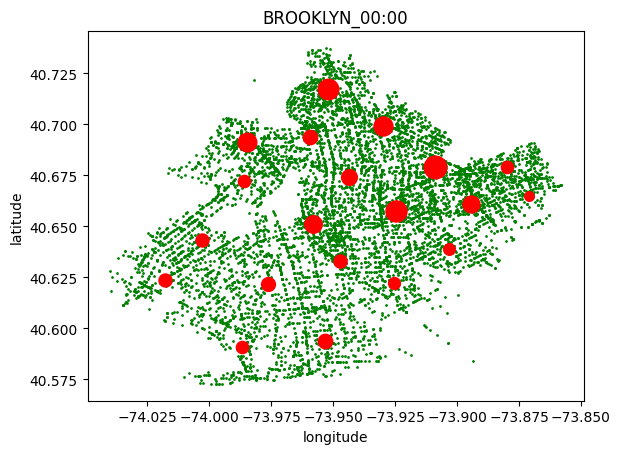

In [7]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_00:00")

In [8]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.65140794011975, -73.95821835329339, 505],
 [40.591042255397724, -73.98682290113636, 352],
 [40.66513072581817, -73.87098217490909, 275],
 [40.62237765409356, -73.92528729181285, 342],
 [40.643420780620154, -74.0028067111111, 376],
 [40.69944285831811, -73.93000832175501, 547],
 [40.691162498324026, -73.98470313798883, 537],
 [40.679046256288345, -73.90887704187116, 652],
 [40.59362387990315, -73.9534479755448, 415],
 [40.679234553125, -73.87996101250002, 352],
 [40.623613381167104, -74.01780414588859, 375],
 [40.62179103384224, -73.97624112086514, 399],
 [40.71754388121826, -73.95224592605751, 591],
 [40.65738964662274, -73.92445923970347, 606],
 [40.69375716383495, -73.95934581359222, 412],
 [40.67438527417219, -73.94375574437086, 453],
 [40.66106840082136, -73.89454269671458, 488],
 [40.63311020820105, -73.94706013148148, 380],
 [40.67211275155807, -73.98590440878186, 353],
 [40.63880209791045, -73.90330431999999, 334]]

### 01:00

In [9]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='01:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+------------------+----------+--------+--------+--------------------+
|          latitude| longitude| borough|    time|            features|
+------------------+----------+--------+--------+--------------------+
|         40.642986| -74.01621|BROOKLYN|01:00:00|[40.642986,-74.01...|
|         40.683872| -73.95998|BROOKLYN|01:00:00|[40.683872,-73.95...|
|         40.658466| -73.96049|BROOKLYN|01:00:00|[40.658466,-73.96...|
|40.602683999999996| -73.94232|BROOKLYN|01:00:00|[40.6026839999999...|
|         40.686066|-73.971436|BROOKLYN|01:00:00|[40.686066,-73.97...|
|         40.632145|-73.952736|BROOKLYN|01:00:00|[40.632145,-73.95...|
|          40.62051| -73.99248|BROOKLYN|01:00:00|[40.62051,-73.99248]|
|         40.666775| -73.97836|BROOKLYN|01:00:00|[40.666775,-73.97...|
|         40.672333|-73.901764|BROOKLYN|01:00:00|[40.672333,-73.90...|
|         40.655834| -73.98123|BROOKLYN|01:00:00|[40.655834,-73.98...|
|         40.643894| -73.93826|BROOKLYN|01:00:00|[40.643894,-73.93...|
|     

In [10]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+------------------+----------+--------+--------+--------------------+----------+
|          latitude| longitude| borough|    time|            features|prediction|
+------------------+----------+--------+--------+--------------------+----------+
|         40.642986| -74.01621|BROOKLYN|01:00:00|[40.642986,-74.01...|         1|
|         40.683872| -73.95998|BROOKLYN|01:00:00|[40.683872,-73.95...|        15|
|         40.658466| -73.96049|BROOKLYN|01:00:00|[40.658466,-73.96...|        17|
|40.602683999999996| -73.94232|BROOKLYN|01:00:00|[40.6026839999999...|        12|
|         40.686066|-73.971436|BROOKLYN|01:00:00|[40.686066,-73.97...|        15|
|         40.632145|-73.952736|BROOKLYN|01:00:00|[40.632145,-73.95...|        17|
|          40.62051| -73.99248|BROOKLYN|01:00:00|[40.62051,-73.99248]|         6|
|         40.666775| -73.97836|BROOKLYN|01:00:00|[40.666775,-73.97...|        11|
|         40.672333|-73.901764|BROOKLYN|01:00:00|[40.672333,-73.90...|        19|
|         40.655

Text(0.5, 1.0, 'BROOKLYN_01:00')

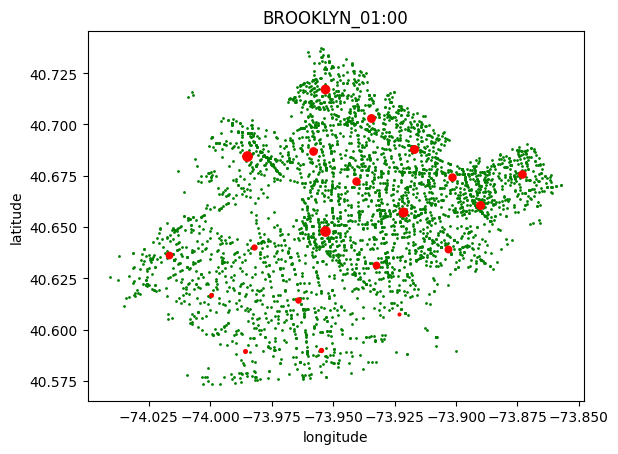

In [11]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_01:00")

In [12]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.703239134259256, -73.93444437314814, 216],
 [40.63633820054644, -74.01664880437157, 183],
 [40.65748793510204, -73.92174054408164, 245],
 [40.67583043961351, -73.87296526618358, 207],
 [40.64019551142857, -73.98202578071427, 140],
 [40.61418014041096, -73.96415438561644, 146],
 [40.61671764757281, -73.99956900291261, 103],
 [40.71740077041666, -73.95344006791667, 240],
 [40.63146295714286, -73.93257134945055, 182],
 [40.60740319342104, -73.92314185000001, 76],
 [40.68810335642202, -73.91718931467891, 218],
 [40.684732059328354, -73.98482961865672, 268],
 [40.589967388596484, -73.95500547192984, 114],
 [40.67247236980199, -73.94067442623763, 202],
 [40.66093621369862, -73.8900281109589, 219],
 [40.68701996047619, -73.95835111285714, 210],
 [40.63918197204302, -73.90321504623657, 186],
 [40.647942674157306, -73.95318584681648, 267],
 [40.58933277809524, -73.98599753809525, 105],
 [40.67413756798028, -73.90169398325125, 203]]

### 02:00

In [13]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='02:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
| 40.67539| -73.88113|BROOKLYN|02:00:00|[40.67539,-73.88113]|
| 40.67816|-73.897484|BROOKLYN|02:00:00|[40.67816,-73.897...|
|40.675106| -73.97714|BROOKLYN|02:00:00|[40.675106,-73.97...|
| 40.68274| -73.97822|BROOKLYN|02:00:00|[40.68274,-73.97822]|
|40.700726| -73.94194|BROOKLYN|02:00:00|[40.700726,-73.94...|
|  40.6238| -73.92351|BROOKLYN|02:00:00| [40.6238,-73.92351]|
|40.601017| -73.95066|BROOKLYN|02:00:00|[40.601017,-73.95...|
|40.654133| -73.91234|BROOKLYN|02:00:00|[40.654133,-73.91...|
|40.643005| -73.95263|BROOKLYN|02:00:00|[40.643005,-73.95...|
| 40.69663| -73.91857|BROOKLYN|02:00:00|[40.69663,-73.91857]|
| 40.71727| -73.96286|BROOKLYN|02:00:00|[40.71727,-73.96286]|
| 40.67956|  -73.8989|BROOKLYN|02:00:00| [40.67956,-73.8989]|
|40.698265| -73.93399|BROOKLYN|02:00:00|[40.698265,-73.93...|
|40.6417

In [14]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
| 40.67539| -73.88113|BROOKLYN|02:00:00|[40.67539,-73.88113]|         5|
| 40.67816|-73.897484|BROOKLYN|02:00:00|[40.67816,-73.897...|        11|
|40.675106| -73.97714|BROOKLYN|02:00:00|[40.675106,-73.97...|         7|
| 40.68274| -73.97822|BROOKLYN|02:00:00|[40.68274,-73.97822]|         7|
|40.700726| -73.94194|BROOKLYN|02:00:00|[40.700726,-73.94...|        14|
|  40.6238| -73.92351|BROOKLYN|02:00:00| [40.6238,-73.92351]|        16|
|40.601017| -73.95066|BROOKLYN|02:00:00|[40.601017,-73.95...|        18|
|40.654133| -73.91234|BROOKLYN|02:00:00|[40.654133,-73.91...|         9|
|40.643005| -73.95263|BROOKLYN|02:00:00|[40.643005,-73.95...|         0|
| 40.69663| -73.91857|BROOKLYN|02:00:00|[40.69663,-73.91857]|         1|
| 40.71727| -73.96286|BROOKLYN|02:00:00|[40.71727,-

Text(0.5, 1.0, 'BROOKLYN_02:00')

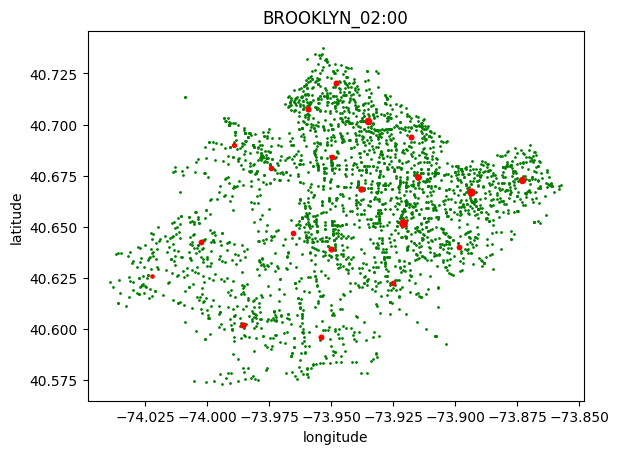

In [15]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_02:00")

In [16]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.638999428467145, -73.95013389562043, 137],
 [40.693699085714286, -73.91765879699247, 133],
 [40.690120629059834, -73.98934784358975, 113],
 [40.60206467916666, -73.9853764298611, 144],
 [40.68417659919354, -73.94970156693549, 128],
 [40.672976980924865, -73.87306602080925, 173],
 [40.62579725, -74.02205190543478, 92],
 [40.678824387603306, -73.97415020991737, 122],
 [40.67421704177215, -73.91477248164557, 158],
 [40.651557745283014, -73.9210500933962, 212],
 [40.64007998425197, -73.89836518740157, 127],
 [40.66713779554455, -73.89355693712872, 202],
 [40.70734779708028, -73.95923247883212, 137],
 [40.668615267808214, -73.93777204041095, 146],
 [40.70170315921788, -73.93505248826816, 179],
 [40.64666442131147, -73.96551794180327, 122],
 [40.622551544800004, -73.92511458000001, 125],
 [40.72032137611941, -73.94816107537314, 134],
 [40.59581568484849, -73.9540904068182, 132],
 [40.64255227559055, -74.00237048976378, 126]]

### 03:00

In [17]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='03:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
| 40.63947|-73.902756|BROOKLYN|03:00:00|[40.63947,-73.902...|
| 40.65958| -73.89247|BROOKLYN|03:00:00|[40.65958,-73.89247]|
|40.619396|-73.969574|BROOKLYN|03:00:00|[40.619396,-73.96...|
|40.667377|-73.880394|BROOKLYN|03:00:00|[40.667377,-73.88...|
|40.702938| -73.95026|BROOKLYN|03:00:00|[40.702938,-73.95...|
| 40.65719|-73.927055|BROOKLYN|03:00:00|[40.65719,-73.927...|
|40.655754| -73.92403|BROOKLYN|03:00:00|[40.655754,-73.92...|
| 40.70239|-73.924644|BROOKLYN|03:00:00|[40.70239,-73.924...|
| 40.66339| -73.95092|BROOKLYN|03:00:00|[40.66339,-73.95092]|
|40.703434| -73.96035|BROOKLYN|03:00:00|[40.703434,-73.96...|
| 40.68651|-73.954544|BROOKLYN|03:00:00|[40.68651,-73.954...|
|  40.6802|-73.953285|BROOKLYN|03:00:00|[40.6802,-73.953285]|
| 40.67066|-73.904205|BROOKLYN|03:00:00|[40.67066,-73.904...|
|40.6889

In [18]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
| 40.63947|-73.902756|BROOKLYN|03:00:00|[40.63947,-73.902...|        15|
| 40.65958| -73.89247|BROOKLYN|03:00:00|[40.65958,-73.89247]|        19|
|40.619396|-73.969574|BROOKLYN|03:00:00|[40.619396,-73.96...|         8|
|40.667377|-73.880394|BROOKLYN|03:00:00|[40.667377,-73.88...|         1|
|40.702938| -73.95026|BROOKLYN|03:00:00|[40.702938,-73.95...|         3|
| 40.65719|-73.927055|BROOKLYN|03:00:00|[40.65719,-73.927...|        18|
|40.655754| -73.92403|BROOKLYN|03:00:00|[40.655754,-73.92...|        18|
| 40.70239|-73.924644|BROOKLYN|03:00:00|[40.70239,-73.924...|        16|
| 40.66339| -73.95092|BROOKLYN|03:00:00|[40.66339,-73.95092]|        14|
|40.703434| -73.96035|BROOKLYN|03:00:00|[40.703434,-73.96...|         3|
| 40.68651|-73.954544|BROOKLYN|03:00:00|[40.68651,-

Text(0.5, 1.0, 'BROOKLYN_03:00')

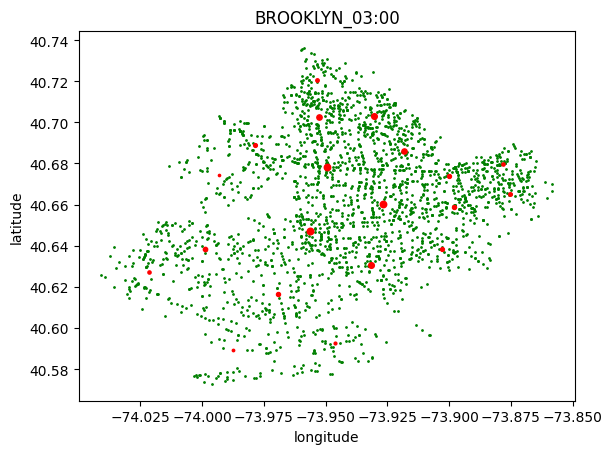

In [19]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_03:00")

In [20]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.64693048776596, -73.95623317925532, 189],
 [40.66516280673077, -73.87531680865386, 104],
 [40.62729691612903, -74.02160247204301, 93],
 [40.70247633896105, -73.95250901948052, 154],
 [40.67417412461539, -73.99331237076923, 65],
 [40.6308120152439, -73.93174414207317, 164],
 [40.58916683714285, -73.98752711857142, 70],
 [40.592850455000004, -73.94613314125, 80],
 [40.61665431355933, -73.96945263135594, 117],
 [40.686291677483446, -73.91822630463575, 151],
 [40.67980030425532, -73.87815234787232, 94],
 [40.68902371284403, -73.9785109321101, 109],
 [40.720448272, -73.953505303, 100],
 [40.674128141592924, -73.90016793893803, 113],
 [40.6780787091398, -73.94928454946239, 186],
 [40.638489811711715, -73.90281662072073, 111],
 [40.70312272699387, -73.93028615460122, 163],
 [40.6382438136, -73.9989681912, 125],
 [40.660409047027024, -73.92695051891891, 185],
 [40.658816455172406, -73.89798583793103, 116]]

### 04:00

In [21]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='04:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+------------------+--------+--------+--------------------+
| latitude|         longitude| borough|    time|            features|
+---------+------------------+--------+--------+--------------------+
|40.692356|         -73.94282|BROOKLYN|04:00:00|[40.692356,-73.94...|
|40.689426|         -73.94223|BROOKLYN|04:00:00|[40.689426,-73.94...|
| 40.64615|         -73.93242|BROOKLYN|04:00:00|[40.64615,-73.93242]|
| 40.62126|         -74.03143|BROOKLYN|04:00:00|[40.62126,-74.03143]|
|40.596478|         -73.96523|BROOKLYN|04:00:00|[40.596478,-73.96...|
|40.665993|          -73.8858|BROOKLYN|04:00:00|[40.665993,-73.8858]|
| 40.65317|        -73.866875|BROOKLYN|04:00:00|[40.65317,-73.866...|
|40.643856|         -73.95175|BROOKLYN|04:00:00|[40.643856,-73.95...|
|40.678715|         -73.89281|BROOKLYN|04:00:00|[40.678715,-73.89...|
| 40.65993|        -73.891655|BROOKLYN|04:00:00|[40.65993,-73.891...|
|40.735226|        -73.958466|BROOKLYN|04:00:00|[40.735226,-73.95...|
| 40.64601|         

In [22]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+------------------+--------+--------+--------------------+----------+
| latitude|         longitude| borough|    time|            features|prediction|
+---------+------------------+--------+--------+--------------------+----------+
|40.692356|         -73.94282|BROOKLYN|04:00:00|[40.692356,-73.94...|         6|
|40.689426|         -73.94223|BROOKLYN|04:00:00|[40.689426,-73.94...|         6|
| 40.64615|         -73.93242|BROOKLYN|04:00:00|[40.64615,-73.93242]|        12|
| 40.62126|         -74.03143|BROOKLYN|04:00:00|[40.62126,-74.03143]|         7|
|40.596478|         -73.96523|BROOKLYN|04:00:00|[40.596478,-73.96...|        19|
|40.665993|          -73.8858|BROOKLYN|04:00:00|[40.665993,-73.8858]|        11|
| 40.65317|        -73.866875|BROOKLYN|04:00:00|[40.65317,-73.866...|         3|
|40.643856|         -73.95175|BROOKLYN|04:00:00|[40.643856,-73.95...|        17|
|40.678715|         -73.89281|BROOKLYN|04:00:00|[40.678715,-73.89...|        11|
| 40.65993|        -73.89165

Text(0.5, 1.0, 'BROOKLYN_04:00')

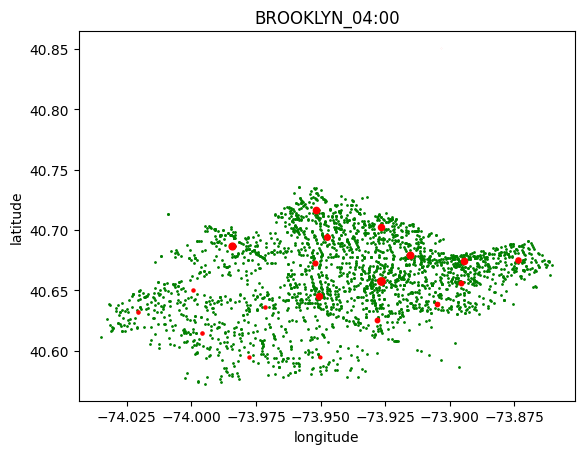

In [23]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_04:00")

In [24]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.7164453237569, -73.95194343756906, 181],
 [40.67943572157894, -73.91553484368421, 190],
 [40.63577735730336, -73.97159981011234, 89],
 [40.67506583576159, -73.87378610993377, 151],
 [40.68636761581632, -73.98441505510202, 196],
 [40.625008415748034, -73.92822945511811, 127],
 [40.69444311499999, -73.947607951875, 160],
 [40.63212621630435, -74.0207485097826, 92],
 [40.672848597761195, -73.9522936716418, 134],
 [40.850876, -73.903595, 1],
 [40.70225293163842, -73.92646127062146, 177],
 [40.674147926256985, -73.89462111899442, 179],
 [40.657803607476644, -73.92667532803738, 214],
 [40.65015091573034, -73.99955736067415, 89],
 [40.594899079487185, -73.950316475641, 78],
 [40.61429507826087, -73.99604331956523, 92],
 [40.65574465076922, -73.8955662623077, 130],
 [40.64511126114286, -73.95059226971428, 175],
 [40.638580932258066, -73.90487687741934, 124],
 [40.59447705747125, -73.9778446862069, 87]]

### 05:00

In [25]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='05:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+------------------+----------+--------+--------+--------------------+
|          latitude| longitude| borough|    time|            features|
+------------------+----------+--------+--------+--------------------+
|          40.60784|-73.961975|BROOKLYN|05:00:00|[40.60784,-73.961...|
|         40.627735|-73.920105|BROOKLYN|05:00:00|[40.627735,-73.92...|
|          40.65047|-73.917366|BROOKLYN|05:00:00|[40.65047,-73.917...|
|          40.68837| -73.98056|BROOKLYN|05:00:00|[40.68837,-73.98056]|
|          40.67816| -74.01416|BROOKLYN|05:00:00|[40.67816,-74.01416]|
|          40.68812|  -73.9117|BROOKLYN|05:00:00| [40.68812,-73.9117]|
|40.678566000000004| -73.98778|BROOKLYN|05:00:00|[40.6785660000000...|
|         40.703033|  -73.9599|BROOKLYN|05:00:00|[40.703033,-73.9599]|
|         40.700726| -73.94194|BROOKLYN|05:00:00|[40.700726,-73.94...|
|         40.669975| -73.91988|BROOKLYN|05:00:00|[40.669975,-73.91...|
|         40.694687| -73.95521|BROOKLYN|05:00:00|[40.694687,-73.95...|
|     

In [26]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+------------------+----------+--------+--------+--------------------+----------+
|          latitude| longitude| borough|    time|            features|prediction|
+------------------+----------+--------+--------+--------------------+----------+
|          40.60784|-73.961975|BROOKLYN|05:00:00|[40.60784,-73.961...|         5|
|         40.627735|-73.920105|BROOKLYN|05:00:00|[40.627735,-73.92...|         3|
|          40.65047|-73.917366|BROOKLYN|05:00:00|[40.65047,-73.917...|         6|
|          40.68837| -73.98056|BROOKLYN|05:00:00|[40.68837,-73.98056]|         4|
|          40.67816| -74.01416|BROOKLYN|05:00:00|[40.67816,-74.01416]|         4|
|          40.68812|  -73.9117|BROOKLYN|05:00:00| [40.68812,-73.9117]|         1|
|40.678566000000004| -73.98778|BROOKLYN|05:00:00|[40.6785660000000...|         4|
|         40.703033|  -73.9599|BROOKLYN|05:00:00|[40.703033,-73.9599]|        14|
|         40.700726| -73.94194|BROOKLYN|05:00:00|[40.700726,-73.94...|        11|
|         40.669

Text(0.5, 1.0, 'BROOKLYN_05:00')

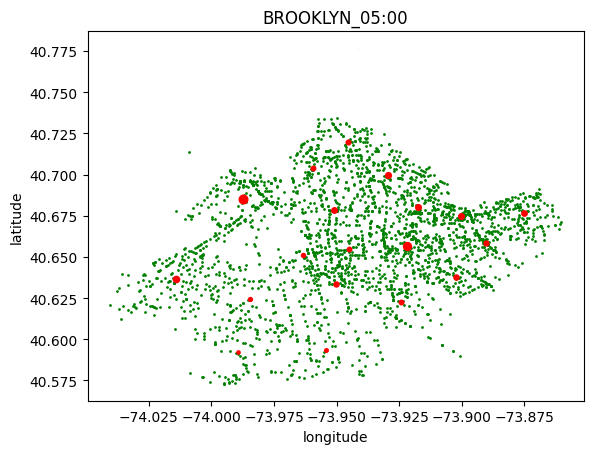

In [27]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_05:00")

In [28]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.651198743589745, -73.96359092564103, 117],
 [40.68059240429449, -73.91760547300612, 163],
 [40.719523957777774, -73.94546914814815, 135],
 [40.62239789465649, -73.92440296335877, 131],
 [40.68514928795181, -73.98722389598394, 249],
 [40.59374779223301, -73.95436265922329, 103],
 [40.656477403056776, -73.92181264585153, 229],
 [40.592071995744675, -73.98924726276596, 94],
 [40.62437222162163, -73.98458061261262, 111],
 [40.65500983671875, -73.94502616250001, 128],
 [40.65840421571427, -73.89023791142857, 140],
 [40.69961922619047, -73.92953102916667, 168],
 [40.636741067039104, -74.01433726201117, 179],
 [40.67463320122699, -73.90027592515338, 163],
 [40.7041522, -73.95941178372094, 129],
 [40.7769, -73.9413, 1],
 [40.637988033783785, -73.90223868851353, 148],
 [40.67850201509434, -73.95114371761007, 159],
 [40.676847439354844, -73.87536035290324, 155],
 [40.63360019034483, -73.95040497655172, 145]]

### 06:00

In [29]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='06:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
|40.673676| -73.86576|BROOKLYN|06:00:00|[40.673676,-73.86...|
|40.714207| -73.92817|BROOKLYN|06:00:00|[40.714207,-73.92...|
|40.691822| -73.92223|BROOKLYN|06:00:00|[40.691822,-73.92...|
|40.702194| -73.93587|BROOKLYN|06:00:00|[40.702194,-73.93...|
|40.669067|  -73.9878|BROOKLYN|06:00:00|[40.669067,-73.9878]|
| 40.64884| -73.95102|BROOKLYN|06:00:00|[40.64884,-73.95102]|
|40.673016| -73.89718|BROOKLYN|06:00:00|[40.673016,-73.89...|
| 40.67148|-73.898674|BROOKLYN|06:00:00|[40.67148,-73.898...|
|40.640236| -73.90598|BROOKLYN|06:00:00|[40.640236,-73.90...|
|40.655758|-73.873505|BROOKLYN|06:00:00|[40.655758,-73.87...|
|40.673706| -73.90118|BROOKLYN|06:00:00|[40.673706,-73.90...|
|40.623367|-73.989494|BROOKLYN|06:00:00|[40.623367,-73.98...|
|40.726547| -73.94838|BROOKLYN|06:00:00|[40.726547,-73.94...|
|40.6480

In [30]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
|40.673676| -73.86576|BROOKLYN|06:00:00|[40.673676,-73.86...|        11|
|40.714207| -73.92817|BROOKLYN|06:00:00|[40.714207,-73.92...|        12|
|40.691822| -73.92223|BROOKLYN|06:00:00|[40.691822,-73.92...|        12|
|40.702194| -73.93587|BROOKLYN|06:00:00|[40.702194,-73.93...|        12|
|40.669067|  -73.9878|BROOKLYN|06:00:00|[40.669067,-73.9878]|         9|
| 40.64884| -73.95102|BROOKLYN|06:00:00|[40.64884,-73.95102]|         4|
|40.673016| -73.89718|BROOKLYN|06:00:00|[40.673016,-73.89...|        16|
| 40.67148|-73.898674|BROOKLYN|06:00:00|[40.67148,-73.898...|        16|
|40.640236| -73.90598|BROOKLYN|06:00:00|[40.640236,-73.90...|         5|
|40.655758|-73.873505|BROOKLYN|06:00:00|[40.655758,-73.87...|        11|
|40.673706| -73.90118|BROOKLYN|06:00:00|[40.673706,

Text(0.5, 1.0, 'BROOKLYN_06:00')

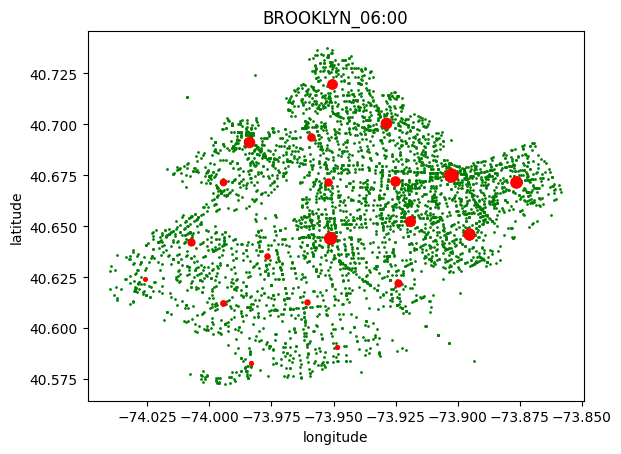

In [31]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_06:00")

In [32]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.67176391497584, -73.95210257439614, 206],
 [40.652395212720855, -73.91898606607772, 282],
 [40.58297816306307, -73.98339983513513, 111],
 [40.635432439333336, -73.97697193, 150],
 [40.64420030615836, -73.95132920703811, 341],
 [40.645902755873, -73.89535825111112, 316],
 [40.691120234256054, -73.98414713840829, 291],
 [40.642148531472074, -74.00761014213197, 197],
 [40.61218136815286, -73.99465769363057, 157],
 [40.67148949344262, -73.99439375409837, 182],
 [40.719742320788534, -73.9504691985663, 272],
 [40.67170322098765, -73.87652360740739, 324],
 [40.700783109699, -73.92889243946487, 299],
 [40.62408613962264, -74.02585054716981, 106],
 [40.69389535560976, -73.95893158195122, 209],
 [40.67239881884616, -73.92529597230771, 265],
 [40.6753192047619, -73.902457710582, 376],
 [40.612951152739726, -73.96074677123286, 146],
 [40.59049728684211, -73.94869445175438, 114],
 [40.6218466532995, -73.9240193532995, 197]]

### 07:00

In [33]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='07:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
|40.613926|-74.030174|BROOKLYN|07:00:00|[40.613926,-74.03...|
|40.591137| -73.97752|BROOKLYN|07:00:00|[40.591137,-73.97...|
|  40.6783| -73.88988|BROOKLYN|07:00:00| [40.6783,-73.88988]|
|40.599907| -73.94664|BROOKLYN|07:00:00|[40.599907,-73.94...|
|40.611477| -73.94883|BROOKLYN|07:00:00|[40.611477,-73.94...|
|40.673634| -73.89294|BROOKLYN|07:00:00|[40.673634,-73.89...|
|40.655895|-73.898224|BROOKLYN|07:00:00|[40.655895,-73.89...|
|40.638313| -73.95751|BROOKLYN|07:00:00|[40.638313,-73.95...|
|40.607876| -73.92554|BROOKLYN|07:00:00|[40.607876,-73.92...|
|40.679935| -73.91389|BROOKLYN|07:00:00|[40.679935,-73.91...|
|40.709164| -73.93708|BROOKLYN|07:00:00|[40.709164,-73.93...|
|40.620525| -74.03228|BROOKLYN|07:00:00|[40.620525,-74.03...|
|40.672108| -73.87671|BROOKLYN|07:00:00|[40.672108,-73.87...|
|40.5808

In [34]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
|40.613926|-74.030174|BROOKLYN|07:00:00|[40.613926,-74.03...|         2|
|40.591137| -73.97752|BROOKLYN|07:00:00|[40.591137,-73.97...|        13|
|  40.6783| -73.88988|BROOKLYN|07:00:00| [40.6783,-73.88988]|         0|
|40.599907| -73.94664|BROOKLYN|07:00:00|[40.599907,-73.94...|         4|
|40.611477| -73.94883|BROOKLYN|07:00:00|[40.611477,-73.94...|        15|
|40.673634| -73.89294|BROOKLYN|07:00:00|[40.673634,-73.89...|         0|
|40.655895|-73.898224|BROOKLYN|07:00:00|[40.655895,-73.89...|        10|
|40.638313| -73.95751|BROOKLYN|07:00:00|[40.638313,-73.95...|        17|
|40.607876| -73.92554|BROOKLYN|07:00:00|[40.607876,-73.92...|         4|
|40.679935| -73.91389|BROOKLYN|07:00:00|[40.679935,-73.91...|         0|
|40.709164| -73.93708|BROOKLYN|07:00:00|[40.709164,

Text(0.5, 1.0, 'BROOKLYN_07:00')

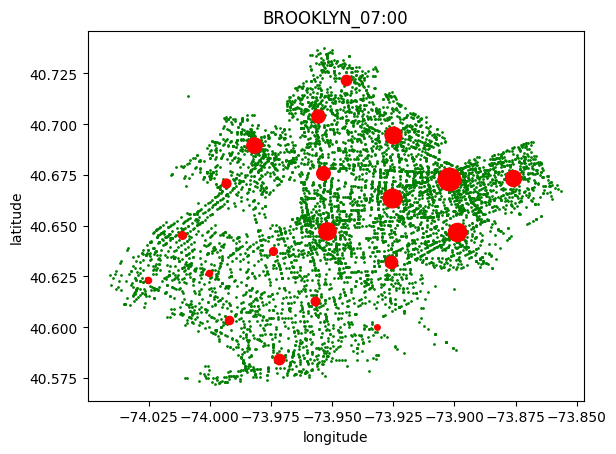

In [35]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_07:00")

In [36]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.67285657882534, -73.90214795780525, 646],
 [40.67349991223176, -73.87601827253216, 460],
 [40.62309187068965, -74.02511631551725, 177],
 [40.67113393618677, -73.99327101945526, 256],
 [40.60027628354429, -73.9317109113924, 157],
 [40.721618255033555, -73.94414906308725, 298],
 [40.66338172809612, -73.92569651312384, 538],
 [40.64538470137615, -74.01144703853211, 219],
 [40.603502942978736, -73.99197771234043, 236],
 [40.69452717722567, -73.92500626231885, 482],
 [40.646644004380946, -73.89890397923809, 524],
 [40.63767761160714, -73.97414933794643, 225],
 [40.675879971649486, -73.95380817293814, 392],
 [40.58433081960133, -73.97179297873755, 301],
 [40.626917945810064, -74.00040009944135, 178],
 [40.612888945528454, -73.9571007195122, 247],
 [40.68946999727273, -73.9821031665909, 443],
 [40.64741834969819, -73.95219430402415, 498],
 [40.70384811216931, -73.95584352169314, 378],
 [40.63202048418079, -73.92585049067797, 354]]

### 08:00

In [37]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='08:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
|40.658413|  -73.9171|BROOKLYN|08:00:00|[40.658413,-73.9171]|
|40.676403| -73.96287|BROOKLYN|08:00:00|[40.676403,-73.96...|
|40.624622| -73.97598|BROOKLYN|08:00:00|[40.624622,-73.97...|
| 40.63311| -73.97217|BROOKLYN|08:00:00|[40.63311,-73.97217]|
|  40.6569|-73.907486|BROOKLYN|08:00:00|[40.6569,-73.907486]|
| 40.61578| -73.99995|BROOKLYN|08:00:00|[40.61578,-73.99995]|
|40.614063| -74.01393|BROOKLYN|08:00:00|[40.614063,-74.01...|
|  40.6635| -73.94276|BROOKLYN|08:00:00| [40.6635,-73.94276]|
|40.600883|-73.958694|BROOKLYN|08:00:00|[40.600883,-73.95...|
|40.694996| -73.97022|BROOKLYN|08:00:00|[40.694996,-73.97...|
|40.684475| -73.97408|BROOKLYN|08:00:00|[40.684475,-73.97...|
|40.608204|-73.920715|BROOKLYN|08:00:00|[40.608204,-73.92...|
|40.624893|-73.934326|BROOKLYN|08:00:00|[40.624893,-73.93...|
| 40.607

In [38]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
|40.658413|  -73.9171|BROOKLYN|08:00:00|[40.658413,-73.9171]|        14|
|40.676403| -73.96287|BROOKLYN|08:00:00|[40.676403,-73.96...|        16|
|40.624622| -73.97598|BROOKLYN|08:00:00|[40.624622,-73.97...|        19|
| 40.63311| -73.97217|BROOKLYN|08:00:00|[40.63311,-73.97217]|        19|
|  40.6569|-73.907486|BROOKLYN|08:00:00|[40.6569,-73.907486]|         0|
| 40.61578| -73.99995|BROOKLYN|08:00:00|[40.61578,-73.99995]|        17|
|40.614063| -74.01393|BROOKLYN|08:00:00|[40.614063,-74.01...|        15|
|  40.6635| -73.94276|BROOKLYN|08:00:00| [40.6635,-73.94276]|        14|
|40.600883|-73.958694|BROOKLYN|08:00:00|[40.600883,-73.95...|         6|
|40.694996| -73.97022|BROOKLYN|08:00:00|[40.694996,-73.97...|         1|
|40.684475| -73.97408|BROOKLYN|08:00:00|[40.684475,

Text(0.5, 1.0, 'BROOKLYN_08:00')

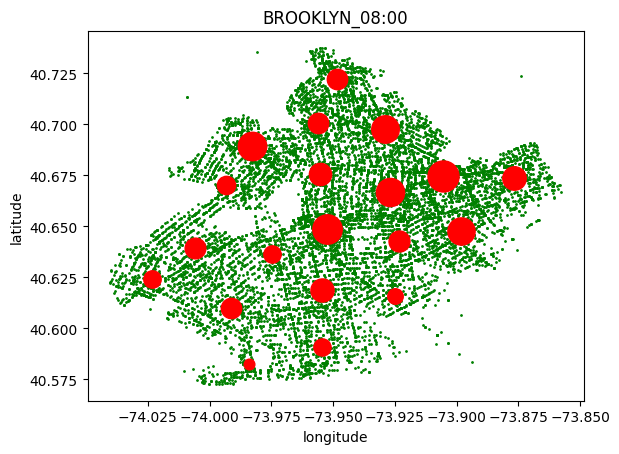

In [39]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_08:00")

In [40]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.64784932127388, -73.89830150458597, 784],
 [40.68929692853659, -73.98268612951222, 820],
 [40.61592659681818, -73.92489792795455, 447],
 [40.63957937960199, -74.00591328822553, 597],
 [40.64891222440758, -73.9522906163507, 848],
 [40.61886588768769, -73.95448296756756, 667],
 [40.59085143266129, -73.95461805806451, 495],
 [40.6748059702009, -73.90552382578124, 894],
 [40.64258364619289, -73.92346544822334, 604],
 [40.670398115151514, -73.9933293376894, 528],
 [40.72227042739496, -73.94839498436976, 588],
 [40.700631775773196, -73.95621594398624, 589],
 [40.697685705131406, -73.92878270137673, 793],
 [40.67364612381657, -73.87685059171596, 676],
 [40.66683915381818, -73.92700349866668, 811],
 [40.62428469441118, -74.02351408722555, 501],
 [40.67578015660965, -73.95545703374805, 642],
 [40.61009630617496, -73.99123737804462, 586],
 [40.5824034685065, -73.9840760305195, 308],
 [40.6365428344758, -73.97491150362902, 499]]

### 09:00

In [41]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='09:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
|40.667202|  -73.8665|BROOKLYN|09:00:00|[40.667202,-73.8665]|
|40.693462|-73.965485|BROOKLYN|09:00:00|[40.693462,-73.96...|
| 40.66806| -73.90394|BROOKLYN|09:00:00|[40.66806,-73.90394]|
|40.637054| -73.98643|BROOKLYN|09:00:00|[40.637054,-73.98...|
|40.714912| -73.94784|BROOKLYN|09:00:00|[40.714912,-73.94...|
| 40.63598|-73.915146|BROOKLYN|09:00:00|[40.63598,-73.915...|
|40.651352| -73.89275|BROOKLYN|09:00:00|[40.651352,-73.89...|
|40.647594| -73.97351|BROOKLYN|09:00:00|[40.647594,-73.97...|
|40.676132|-73.921906|BROOKLYN|09:00:00|[40.676132,-73.92...|
|40.652313| -73.95602|BROOKLYN|09:00:00|[40.652313,-73.95...|
|40.732388|-73.943726|BROOKLYN|09:00:00|[40.732388,-73.94...|
|40.700233| -73.95988|BROOKLYN|09:00:00|[40.700233,-73.95...|
|40.672432|-73.911316|BROOKLYN|09:00:00|[40.672432,-73.91...|
|40.6481

In [42]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
|40.667202|  -73.8665|BROOKLYN|09:00:00|[40.667202,-73.8665]|         2|
|40.693462|-73.965485|BROOKLYN|09:00:00|[40.693462,-73.96...|         4|
| 40.66806| -73.90394|BROOKLYN|09:00:00|[40.66806,-73.90394]|         7|
|40.637054| -73.98643|BROOKLYN|09:00:00|[40.637054,-73.98...|        12|
|40.714912| -73.94784|BROOKLYN|09:00:00|[40.714912,-73.94...|         0|
| 40.63598|-73.915146|BROOKLYN|09:00:00|[40.63598,-73.915...|         3|
|40.651352| -73.89275|BROOKLYN|09:00:00|[40.651352,-73.89...|         9|
|40.647594| -73.97351|BROOKLYN|09:00:00|[40.647594,-73.97...|         8|
|40.676132|-73.921906|BROOKLYN|09:00:00|[40.676132,-73.92...|        10|
|40.652313| -73.95602|BROOKLYN|09:00:00|[40.652313,-73.95...|         8|
|40.732388|-73.943726|BROOKLYN|09:00:00|[40.732388,

Text(0.5, 1.0, 'BROOKLYN_09:00')

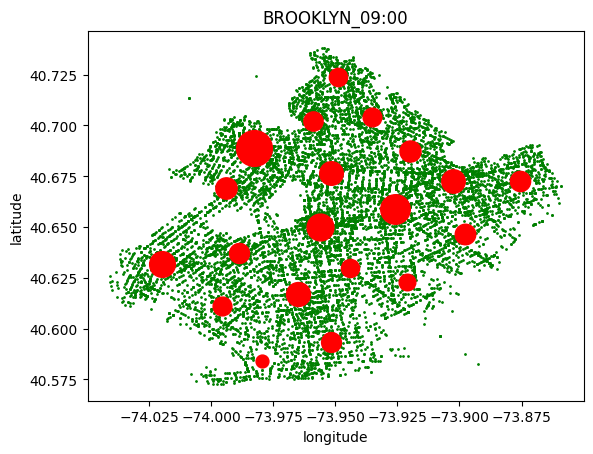

In [43]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_09:00")

In [44]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.723626553700186, -73.94882635597725, 528],
 [40.6168356484104, -73.96523427268785, 689],
 [40.67267500256848, -73.87544852688356, 583],
 [40.62286553481953, -73.92125323481953, 479],
 [40.70200225191256, -73.95881397285974, 556],
 [40.59325889181185, -73.95167636114984, 571],
 [40.66913196515397, -73.9938477554295, 616],
 [40.672373506461085, -73.90242800381793, 676],
 [40.65012092658065, -73.95599976103226, 773],
 [40.646464266554055, -73.89792852111486, 592],
 [40.687257967594114, -73.91975569247137, 607],
 [40.63174416403269, -74.01985733174386, 741],
 [40.63721214312715, -73.98887684896906, 577],
 [40.58400844498645, -73.97958926260162, 370],
 [40.65871104504717, -73.92608270035376, 851],
 [40.68888490915287, -73.98272068276533, 1030],
 [40.61088834659301, -73.9958012519337, 542],
 [40.70392744304267, -73.93538723896106, 540],
 [40.629817275471694, -73.94408087962265, 523],
 [40.67650567952872, -73.95189905434462, 680]]

### 10:00

In [45]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='10:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
|40.638523| -73.92607|BROOKLYN|10:00:00|[40.638523,-73.92...|
|40.637985|  -74.0076|BROOKLYN|10:00:00|[40.637985,-74.0076]|
| 40.67271| -73.97089|BROOKLYN|10:00:00|[40.67271,-73.97089]|
| 40.63874|  -73.8952|BROOKLYN|10:00:00| [40.63874,-73.8952]|
|40.655903| -73.89817|BROOKLYN|10:00:00|[40.655903,-73.89...|
|40.579212|-73.976265|BROOKLYN|10:00:00|[40.579212,-73.97...|
|40.714073| -73.95087|BROOKLYN|10:00:00|[40.714073,-73.95...|
|40.694794| -73.98246|BROOKLYN|10:00:00|[40.694794,-73.98...|
| 40.64606| -74.01648|BROOKLYN|10:00:00|[40.64606,-74.01648]|
| 40.62855|-73.952835|BROOKLYN|10:00:00|[40.62855,-73.952...|
|40.707523| -73.96115|BROOKLYN|10:00:00|[40.707523,-73.96...|
|40.669758| -73.91019|BROOKLYN|10:00:00|[40.669758,-73.91...|
|40.602886|-73.952095|BROOKLYN|10:00:00|[40.602886,-73.95...|
|40.6488

In [46]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
|40.638523| -73.92607|BROOKLYN|10:00:00|[40.638523,-73.92...|         9|
|40.637985|  -74.0076|BROOKLYN|10:00:00|[40.637985,-74.0076]|        19|
| 40.67271| -73.97089|BROOKLYN|10:00:00|[40.67271,-73.97089]|        15|
| 40.63874|  -73.8952|BROOKLYN|10:00:00| [40.63874,-73.8952]|        16|
|40.655903| -73.89817|BROOKLYN|10:00:00|[40.655903,-73.89...|         3|
|40.579212|-73.976265|BROOKLYN|10:00:00|[40.579212,-73.97...|        13|
|40.714073| -73.95087|BROOKLYN|10:00:00|[40.714073,-73.95...|         4|
|40.694794| -73.98246|BROOKLYN|10:00:00|[40.694794,-73.98...|         2|
| 40.64606| -74.01648|BROOKLYN|10:00:00|[40.64606,-74.01648]|         5|
| 40.62855|-73.952835|BROOKLYN|10:00:00|[40.62855,-73.952...|        18|
|40.707523| -73.96115|BROOKLYN|10:00:00|[40.707523,

Text(0.5, 1.0, 'BROOKLYN_10:00')

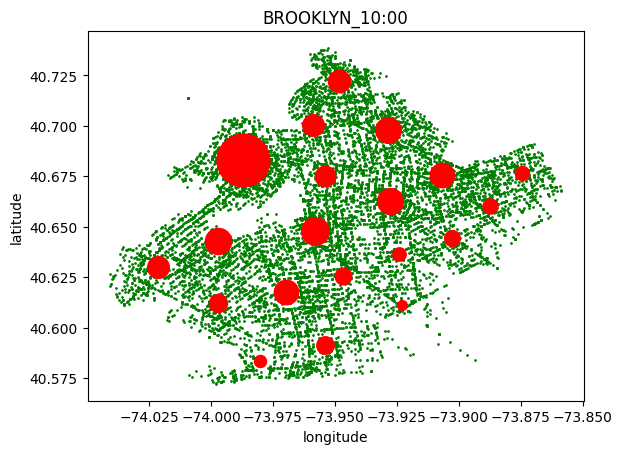

In [47]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_10:00")

In [48]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.617697528226955, -73.96957437659574, 704],
 [40.70004592942123, -73.95873745562702, 621],
 [40.68300581661196, -73.98709395489165, 1522],
 [40.66002422309469, -73.88750814942266, 434],
 [40.722010742902214, -73.94833380141957, 635],
 [40.630156963853516, -74.02116941401276, 625],
 [40.676381126354684, -73.87454187364533, 406],
 [40.612166101158294, -73.99722771756757, 521],
 [40.61134757545127, -73.92303179205776, 280],
 [40.63638545179487, -73.92409583897435, 387],
 [40.67536663319088, -73.90667382250713, 702],
 [40.66289235583892, -73.92790910993288, 745],
 [40.69776034529332, -73.92870988376535, 734],
 [40.58365119455587, -73.98016294154729, 349],
 [40.59137232703777, -73.95410705149105, 503],
 [40.674913734067786, -73.95411990406781, 591],
 [40.644390867328916, -73.90267488322297, 452],
 [40.647945080453965, -73.95786274842371, 793],
 [40.62554564333333, -73.94673007624999, 480],
 [40.64307483094289, -73.99714864236387, 753]]

### 11:00

In [49]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='11:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
|40.635563| -73.89577|BROOKLYN|11:00:00|[40.635563,-73.89...|
|40.617004| -73.96912|BROOKLYN|11:00:00|[40.617004,-73.96...|
|40.631508| -73.90506|BROOKLYN|11:00:00|[40.631508,-73.90...|
|40.727146|-73.954735|BROOKLYN|11:00:00|[40.727146,-73.95...|
|40.698116|-73.977325|BROOKLYN|11:00:00|[40.698116,-73.97...|
| 40.68896| -73.93326|BROOKLYN|11:00:00|[40.68896,-73.93326]|
|40.658672| -73.90019|BROOKLYN|11:00:00|[40.658672,-73.90...|
|40.708363| -73.92401|BROOKLYN|11:00:00|[40.708363,-73.92...|
|  40.6699| -73.95116|BROOKLYN|11:00:00| [40.6699,-73.95116]|
|40.699818|-73.920135|BROOKLYN|11:00:00|[40.699818,-73.92...|
|40.580658|-73.985664|BROOKLYN|11:00:00|[40.580658,-73.98...|
|40.628258| -73.94135|BROOKLYN|11:00:00|[40.628258,-73.94...|
|40.605675| -73.98935|BROOKLYN|11:00:00|[40.605675,-73.98...|
|40.6708

In [50]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
|40.635563| -73.89577|BROOKLYN|11:00:00|[40.635563,-73.89...|         0|
|40.617004| -73.96912|BROOKLYN|11:00:00|[40.617004,-73.96...|         6|
|40.631508| -73.90506|BROOKLYN|11:00:00|[40.631508,-73.90...|        15|
|40.727146|-73.954735|BROOKLYN|11:00:00|[40.727146,-73.95...|         4|
|40.698116|-73.977325|BROOKLYN|11:00:00|[40.698116,-73.97...|         1|
| 40.68896| -73.93326|BROOKLYN|11:00:00|[40.68896,-73.93326]|         5|
|40.658672| -73.90019|BROOKLYN|11:00:00|[40.658672,-73.90...|         0|
|40.708363| -73.92401|BROOKLYN|11:00:00|[40.708363,-73.92...|         5|
|  40.6699| -73.95116|BROOKLYN|11:00:00| [40.6699,-73.95116]|         9|
|40.699818|-73.920135|BROOKLYN|11:00:00|[40.699818,-73.92...|         5|
|40.580658|-73.985664|BROOKLYN|11:00:00|[40.580658,

Text(0.5, 1.0, 'BROOKLYN_11:00')

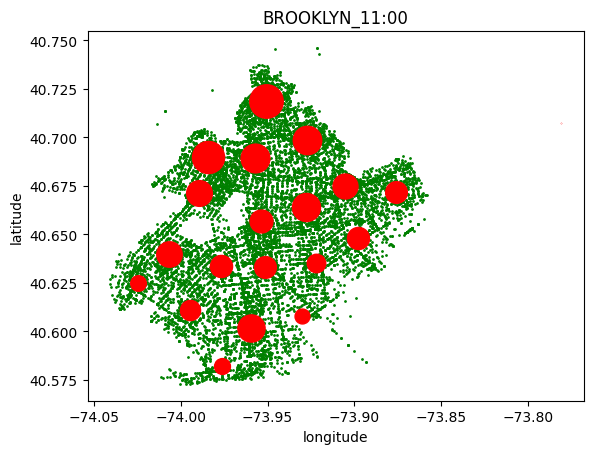

In [51]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_11:00")

In [52]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.648159751419556, -73.8978813192429, 636],
 [40.68992372302771, -73.98409939125801, 925],
 [40.632922695616884, -73.95132631785715, 626],
 [40.671303019459465, -73.98960470310811, 741],
 [40.718752229740936, -73.95112170207254, 964],
 [40.69861498308823, -73.92741831102941, 820],
 [40.601736954092075, -73.9593854124041, 784],
 [40.62493019398664, -74.0249899171492, 449],
 [40.611024310843376, -73.99490671239244, 580],
 [40.65695225996954, -73.95400341811263, 660],
 [40.675092120839174, -73.90561849286713, 719],
 [40.63367376369231, -73.97670444938461, 637],
 [40.67195381007999, -73.87622418144001, 625],
 [40.582113381127996, -73.97655621366594, 458],
 [40.60805187342658, -73.93044793916084, 429],
 [40.63508643421052, -73.92217332612783, 533],
 [40.689169633575766, -73.9571678529697, 829],
 [40.63999882816327, -74.0066984755102, 734],
 [40.70757628571428, -73.78087857142856, 7],
 [40.66411690965346, -73.92778879987624, 809]]

### 12:00

In [53]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='12:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+------------------+----------+--------+--------+--------------------+
|          latitude| longitude| borough|    time|            features|
+------------------+----------+--------+--------+--------------------+
|         40.687534|  -73.9775|BROOKLYN|12:00:00|[40.687534,-73.9775]|
|          40.62417| -73.97048|BROOKLYN|12:00:00|[40.62417,-73.97048]|
|         40.665375|-73.934235|BROOKLYN|12:00:00|[40.665375,-73.93...|
|          40.63063| -74.00923|BROOKLYN|12:00:00|[40.63063,-74.00923]|
|         40.661263|-73.955765|BROOKLYN|12:00:00|[40.661263,-73.95...|
|          40.59692| -73.94122|BROOKLYN|12:00:00|[40.59692,-73.94122]|
|          40.57529| -73.97655|BROOKLYN|12:00:00|[40.57529,-73.97655]|
|          40.70166|-73.961464|BROOKLYN|12:00:00|[40.70166,-73.961...|
|          40.61033| -73.95932|BROOKLYN|12:00:00|[40.61033,-73.95932]|
|          40.65241|  -73.9264|BROOKLYN|12:00:00| [40.65241,-73.9264]|
|         40.620914|  -73.9753|BROOKLYN|12:00:00|[40.620914,-73.9753]|
|     

In [54]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+------------------+----------+--------+--------+--------------------+----------+
|          latitude| longitude| borough|    time|            features|prediction|
+------------------+----------+--------+--------+--------------------+----------+
|         40.687534|  -73.9775|BROOKLYN|12:00:00|[40.687534,-73.9775]|        13|
|          40.62417| -73.97048|BROOKLYN|12:00:00|[40.62417,-73.97048]|        14|
|         40.665375|-73.934235|BROOKLYN|12:00:00|[40.665375,-73.93...|         1|
|          40.63063| -74.00923|BROOKLYN|12:00:00|[40.63063,-74.00923]|         0|
|         40.661263|-73.955765|BROOKLYN|12:00:00|[40.661263,-73.95...|         2|
|          40.59692| -73.94122|BROOKLYN|12:00:00|[40.59692,-73.94122]|         3|
|          40.57529| -73.97655|BROOKLYN|12:00:00|[40.57529,-73.97655]|        16|
|          40.70166|-73.961464|BROOKLYN|12:00:00|[40.70166,-73.961...|         8|
|          40.61033| -73.95932|BROOKLYN|12:00:00|[40.61033,-73.95932]|        19|
|          40.65

Text(0.5, 1.0, 'BROOKLYN_12:00')

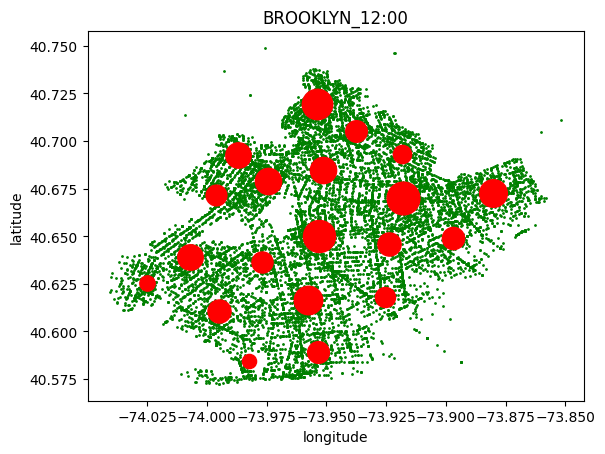

In [55]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_12:00")

In [56]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.6389338629932, -74.00686091278912, 735],
 [40.67022785021052, -73.91777257189473, 944],
 [40.65032256082252, -73.95307293560606, 924],
 [40.589279270494416, -73.95354938851676, 626],
 [40.671552522370625, -73.99598357412353, 599],
 [40.64896768859375, -73.8969856271875, 640],
 [40.6726933195, -73.8804092565, 797],
 [40.62523060429866, -74.02516473846156, 442],
 [40.719328746188864, -73.95385595938568, 876],
 [40.693337707619044, -73.9183383975238, 527],
 [40.6108783756391, -73.99488587398497, 665],
 [40.645906700454546, -73.92389245863636, 668],
 [40.61819943993056, -73.92535218506944, 577],
 [40.678967421400266, -73.97450510792605, 757],
 [40.636603101973684, -73.97697047779606, 608],
 [40.69238409753763, -73.98700229890561, 731],
 [40.58456206403941, -73.98234460665026, 408],
 [40.684529696036996, -73.95138314121532, 757],
 [40.70537827223113, -73.93759208715892, 623],
 [40.616351736906196, -73.95776743800243, 821]]

### 13:00

In [57]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='13:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
|40.701637|-73.942276|BROOKLYN|13:00:00|[40.701637,-73.94...|
| 40.66843| -73.91919|BROOKLYN|13:00:00|[40.66843,-73.91919]|
|40.731613|  -73.9545|BROOKLYN|13:00:00|[40.731613,-73.9545]|
|40.712963| -73.93647|BROOKLYN|13:00:00|[40.712963,-73.93...|
| 40.60118| -73.99098|BROOKLYN|13:00:00|[40.60118,-73.99098]|
| 40.65563| -73.92596|BROOKLYN|13:00:00|[40.65563,-73.92596]|
|40.633114| -73.94928|BROOKLYN|13:00:00|[40.633114,-73.94...|
| 40.59857|  -73.9689|BROOKLYN|13:00:00| [40.59857,-73.9689]|
| 40.69045|-73.959435|BROOKLYN|13:00:00|[40.69045,-73.959...|
|40.700485| -73.93637|BROOKLYN|13:00:00|[40.700485,-73.93...|
|40.666943|-73.890144|BROOKLYN|13:00:00|[40.666943,-73.89...|
|40.669823| -73.90981|BROOKLYN|13:00:00|[40.669823,-73.90...|
|40.708675| -73.93699|BROOKLYN|13:00:00|[40.708675,-73.93...|
| 40.717

In [58]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
|40.701637|-73.942276|BROOKLYN|13:00:00|[40.701637,-73.94...|         2|
| 40.66843| -73.91919|BROOKLYN|13:00:00|[40.66843,-73.91919]|        15|
|40.731613|  -73.9545|BROOKLYN|13:00:00|[40.731613,-73.9545]|         9|
|40.712963| -73.93647|BROOKLYN|13:00:00|[40.712963,-73.93...|         2|
| 40.60118| -73.99098|BROOKLYN|13:00:00|[40.60118,-73.99098]|        16|
| 40.65563| -73.92596|BROOKLYN|13:00:00|[40.65563,-73.92596]|         0|
|40.633114| -73.94928|BROOKLYN|13:00:00|[40.633114,-73.94...|         8|
| 40.59857|  -73.9689|BROOKLYN|13:00:00| [40.59857,-73.9689]|         1|
| 40.69045|-73.959435|BROOKLYN|13:00:00|[40.69045,-73.959...|        17|
|40.700485| -73.93637|BROOKLYN|13:00:00|[40.700485,-73.93...|         2|
|40.666943|-73.890144|BROOKLYN|13:00:00|[40.666943,

Text(0.5, 1.0, 'BROOKLYN_13:00')

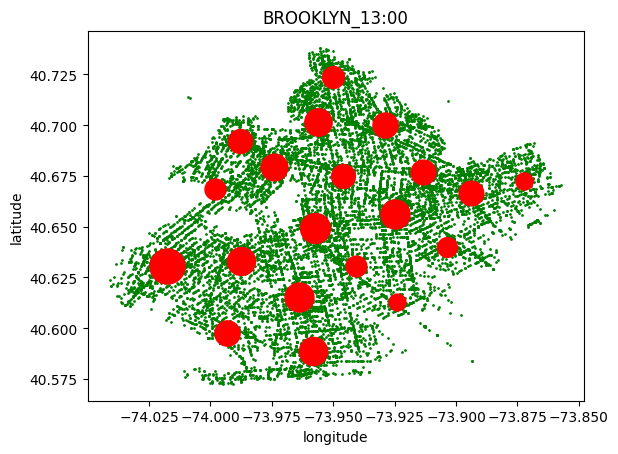

In [59]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_13:00")

In [60]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.65610254479043, -73.92481974622754, 836],
 [40.588520314392056, -73.95810909069478, 810],
 [40.700054658002735, -73.92884330656635, 723],
 [40.6723138729293, -73.87252149050505, 493],
 [40.63043842279485, -74.0178409682854, 1010],
 [40.633128799751866, -73.98769548709677, 806],
 [40.69232916705369, -73.98776292975326, 689],
 [40.66656762774648, -73.89372818563382, 709],
 [40.63045896998342, -73.94060445970149, 598],
 [40.72371755408805, -73.95007454528303, 632],
 [40.649091014484355, -73.95754264774044, 863],
 [40.61532862953181, -73.96403751848739, 834],
 [40.6791745996063, -73.97420974238845, 769],
 [40.63994127826087, -73.90364917478261, 569],
 [40.674777312554745, -73.94604901182481, 686],
 [40.67695210549297, -73.91325582647887, 713],
 [40.59737250548697, -73.99322218422495, 728],
 [40.70157010996169, -73.95615999233716, 787],
 [40.668431297851235, -73.99813092512396, 605],
 [40.61282554, -73.923931986875, 485]]

### 14:00

In [61]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='14:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
|40.635063| -73.94788|BROOKLYN|14:00:00|[40.635063,-73.94...|
|40.624474| -74.00668|BROOKLYN|14:00:00|[40.624474,-74.00...|
|40.687748|-73.980125|BROOKLYN|14:00:00|[40.687748,-73.98...|
| 40.67393|-73.999954|BROOKLYN|14:00:00|[40.67393,-73.999...|
| 40.63864| -74.02245|BROOKLYN|14:00:00|[40.63864,-74.02245]|
| 40.63083| -73.90736|BROOKLYN|14:00:00|[40.63083,-73.90736]|
|40.633682| -73.89868|BROOKLYN|14:00:00|[40.633682,-73.89...|
| 40.62677|-73.946884|BROOKLYN|14:00:00|[40.62677,-73.946...|
|40.708626| -73.94513|BROOKLYN|14:00:00|[40.708626,-73.94...|
|40.633995| -73.98138|BROOKLYN|14:00:00|[40.633995,-73.98...|
|40.586277|  -73.9862|BROOKLYN|14:00:00|[40.586277,-73.9862]|
|40.730198|-73.954254|BROOKLYN|14:00:00|[40.730198,-73.95...|
| 40.70042|-73.956566|BROOKLYN|14:00:00|[40.70042,-73.956...|
| 40.596

In [62]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
|40.635063| -73.94788|BROOKLYN|14:00:00|[40.635063,-73.94...|         9|
|40.624474| -74.00668|BROOKLYN|14:00:00|[40.624474,-74.00...|         7|
|40.687748|-73.980125|BROOKLYN|14:00:00|[40.687748,-73.98...|         1|
| 40.67393|-73.999954|BROOKLYN|14:00:00|[40.67393,-73.999...|        11|
| 40.63864| -74.02245|BROOKLYN|14:00:00|[40.63864,-74.02245]|         7|
| 40.63083| -73.90736|BROOKLYN|14:00:00|[40.63083,-73.90736]|        19|
|40.633682| -73.89868|BROOKLYN|14:00:00|[40.633682,-73.89...|        19|
| 40.62677|-73.946884|BROOKLYN|14:00:00|[40.62677,-73.946...|        13|
|40.708626| -73.94513|BROOKLYN|14:00:00|[40.708626,-73.94...|        18|
|40.633995| -73.98138|BROOKLYN|14:00:00|[40.633995,-73.98...|         3|
|40.586277|  -73.9862|BROOKLYN|14:00:00|[40.586277,

Text(0.5, 1.0, 'BROOKLYN_14:00')

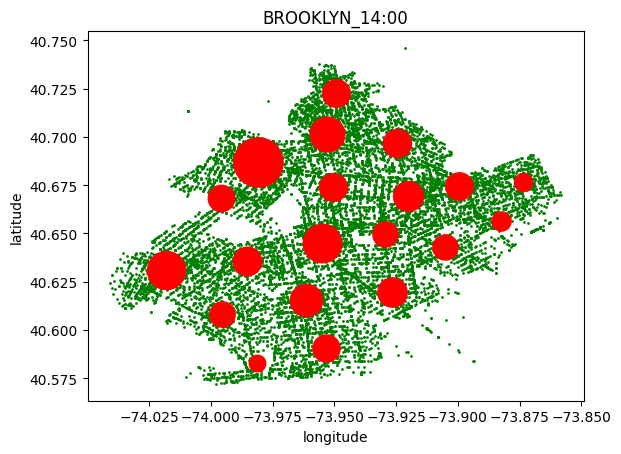

In [63]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_14:00")

In [64]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.59053921800767, -73.95354724878672, 782],
 [40.6869675119634, -73.98101021393387, 1417],
 [40.67437295147625, -73.89968391129653, 789],
 [40.6357242, -73.98521220354522, 823],
 [40.72259966284289, -73.94921463466333, 798],
 [40.69708942413793, -73.92485285923645, 810],
 [40.6084727595946, -73.99530480013514, 731],
 [40.631302441438976, -74.01810598387978, 1098],
 [40.676680580468755, -73.87347708339843, 520],
 [40.645097369161405, -73.95520145951309, 1109],
 [40.65645970054645, -73.88276510000001, 551],
 [40.66834392526315, -73.99580887355262, 760],
 [40.67412262277847, -73.95060147384228, 800],
 [40.615565748068654, -73.96148126416308, 929],
 [40.61968048957347, -73.9267265744076, 843],
 [40.58285334113923, -73.9813745706751, 476],
 [40.64952329031812, -73.92964968589212, 725],
 [40.66966374515012, -73.92011569053118, 861],
 [40.701379949096385, -73.95307097971886, 1000],
 [40.64299545618133, -73.90503486304945, 723]]

### 15:00

In [65]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='15:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
|40.648243|   -73.929|BROOKLYN|15:00:00| [40.648243,-73.929]|
| 40.64366| -73.90067|BROOKLYN|15:00:00|[40.64366,-73.90067]|
| 40.59841| -73.97592|BROOKLYN|15:00:00|[40.59841,-73.97592]|
|40.579445|  -73.9544|BROOKLYN|15:00:00|[40.579445,-73.9544]|
|40.633976| -74.02211|BROOKLYN|15:00:00|[40.633976,-74.02...|
|40.708805| -73.92577|BROOKLYN|15:00:00|[40.708805,-73.92...|
|40.620487|-74.029305|BROOKLYN|15:00:00|[40.620487,-74.02...|
|40.629707| -73.90486|BROOKLYN|15:00:00|[40.629707,-73.90...|
|40.612736| -74.01172|BROOKLYN|15:00:00|[40.612736,-74.01...|
|40.695004|  -73.9525|BROOKLYN|15:00:00|[40.695004,-73.9525]|
| 40.69349| -73.97917|BROOKLYN|15:00:00|[40.69349,-73.97917]|
|40.731422| -73.94641|BROOKLYN|15:00:00|[40.731422,-73.94...|
|40.653873|-74.008156|BROOKLYN|15:00:00|[40.653873,-74.00...|
| 40.688

In [66]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
|40.648243|   -73.929|BROOKLYN|15:00:00| [40.648243,-73.929]|        17|
| 40.64366| -73.90067|BROOKLYN|15:00:00|[40.64366,-73.90067]|        10|
| 40.59841| -73.97592|BROOKLYN|15:00:00|[40.59841,-73.97592]|        14|
|40.579445|  -73.9544|BROOKLYN|15:00:00|[40.579445,-73.9544]|        18|
|40.633976| -74.02211|BROOKLYN|15:00:00|[40.633976,-74.02...|         5|
|40.708805| -73.92577|BROOKLYN|15:00:00|[40.708805,-73.92...|         3|
|40.620487|-74.029305|BROOKLYN|15:00:00|[40.620487,-74.02...|         4|
|40.629707| -73.90486|BROOKLYN|15:00:00|[40.629707,-73.90...|        17|
|40.612736| -74.01172|BROOKLYN|15:00:00|[40.612736,-74.01...|         4|
|40.695004|  -73.9525|BROOKLYN|15:00:00|[40.695004,-73.9525]|         7|
| 40.69349| -73.97917|BROOKLYN|15:00:00|[40.69349,-

Text(0.5, 1.0, 'BROOKLYN_15:00')

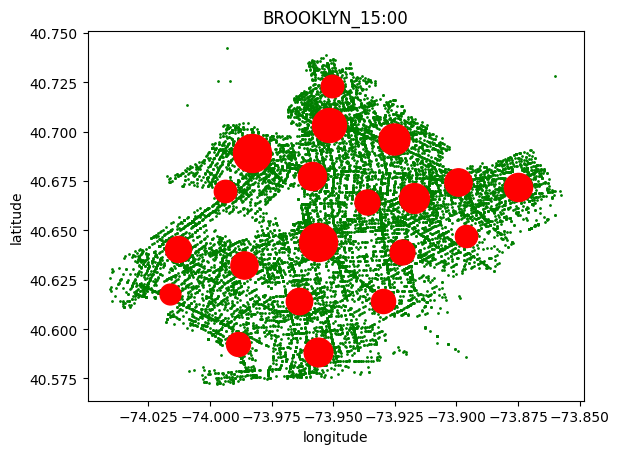

In [67]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_15:00")

In [68]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.67428132944163, -73.89945335558376, 788],
 [40.614066021475615, -73.96406220540185, 760],
 [40.67740965135468, -73.95851393017242, 810],
 [40.69628680804468, -73.92536374156424, 895],
 [40.61769971366667, -74.016167455, 600],
 [40.64040500786666, -74.01299565186666, 750],
 [40.666598818699185, -73.91742509024391, 860],
 [40.703428282807735, -73.95153247802645, 979],
 [40.68932083485401, -73.98300818020073, 1094],
 [40.664555633333336, -73.93636631305557, 721],
 [40.64738370577223, -73.89597505694228, 639],
 [40.6324394454777, -73.98634305235669, 785],
 [40.64415972958904, -73.95616824319634, 1095],
 [40.6720600863132, -73.87516052108509, 810],
 [40.592599079680696, -73.9886024280116, 689],
 [40.669727644961235, -73.99401087488373, 645],
 [40.61412214402878, -73.92973200460433, 695],
 [40.63893644608939, -73.92221989608939, 717],
 [40.588435950425264, -73.95603318201702, 826],
 [40.72304755947205, -73.95051357950311, 650]]

### 16:00

In [69]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='16:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
| 40.67046| -73.88788|BROOKLYN|16:00:00|[40.67046,-73.88788]|
|40.577652| -73.96344|BROOKLYN|16:00:00|[40.577652,-73.96...|
| 40.68651| -73.98378|BROOKLYN|16:00:00|[40.68651,-73.98378]|
|40.696735| -73.93481|BROOKLYN|16:00:00|[40.696735,-73.93...|
|40.632416| -73.94724|BROOKLYN|16:00:00|[40.632416,-73.94...|
|40.689648|  -73.9184|BROOKLYN|16:00:00|[40.689648,-73.9184]|
| 40.66725| -73.88799|BROOKLYN|16:00:00|[40.66725,-73.88799]|
|40.715702| -73.95579|BROOKLYN|16:00:00|[40.715702,-73.95...|
|40.652317| -73.92752|BROOKLYN|16:00:00|[40.652317,-73.92...|
|40.681335| -73.97667|BROOKLYN|16:00:00|[40.681335,-73.97...|
|40.694836| -73.96915|BROOKLYN|16:00:00|[40.694836,-73.96...|
|   40.703| -73.94425|BROOKLYN|16:00:00|  [40.703,-73.94425]|
|40.700813| -73.95447|BROOKLYN|16:00:00|[40.700813,-73.95...|
| 40.654

In [70]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
| 40.67046| -73.88788|BROOKLYN|16:00:00|[40.67046,-73.88788]|        12|
|40.577652| -73.96344|BROOKLYN|16:00:00|[40.577652,-73.96...|         4|
| 40.68651| -73.98378|BROOKLYN|16:00:00|[40.68651,-73.98378]|         7|
|40.696735| -73.93481|BROOKLYN|16:00:00|[40.696735,-73.93...|         3|
|40.632416| -73.94724|BROOKLYN|16:00:00|[40.632416,-73.94...|        16|
|40.689648|  -73.9184|BROOKLYN|16:00:00|[40.689648,-73.9184]|         3|
| 40.66725| -73.88799|BROOKLYN|16:00:00|[40.66725,-73.88799]|        12|
|40.715702| -73.95579|BROOKLYN|16:00:00|[40.715702,-73.95...|        10|
|40.652317| -73.92752|BROOKLYN|16:00:00|[40.652317,-73.92...|        15|
|40.681335| -73.97667|BROOKLYN|16:00:00|[40.681335,-73.97...|         7|
|40.694836| -73.96915|BROOKLYN|16:00:00|[40.694836,

Text(0.5, 1.0, 'BROOKLYN_16:00')

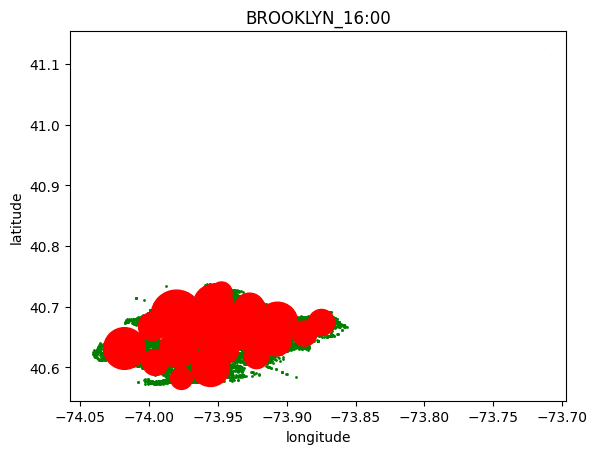

In [71]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_16:00")

In [72]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.66878368796069, -73.99743895294841, 809],
 [40.619482266912854, -73.92251732067949, 698],
 [40.65097467300797, -73.95586159741038, 1002],
 [40.69776376180791, -73.92727141355934, 884],
 [40.58283901714287, -73.97637946650795, 629],
 [40.60123736169244, -73.95536458944495, 1092],
 [40.675440533619955, -73.9066828478074, 1169],
 [40.68646178012338, -73.98030781041811, 1463],
 [41.12615, -73.71353, 1],
 [40.6326498742525, -74.0177586929402, 1200],
 [40.704441600520376, -73.9534114509974, 1153],
 [40.63244840409836, -73.97863027076505, 1094],
 [40.65672285554015, -73.88765058476453, 722],
 [40.609564577453575, -73.99583660278515, 752],
 [40.64344150858165, -73.90751017914184, 832],
 [40.660653298215884, -73.92706258840323, 1125],
 [40.62874687599469, -73.94506138554375, 746],
 [40.7248908461157, -73.94732629752066, 606],
 [40.675516267021266, -73.87478511422873, 752],
 [40.67723135213114, -73.94754438743168, 920]]

### 17:00

In [73]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='17:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
| 40.68158| -73.97463|BROOKLYN|17:00:00|[40.68158,-73.97463]|
|40.623104| -73.95809|BROOKLYN|17:00:00|[40.623104,-73.95...|
|40.710957|-73.951126|BROOKLYN|17:00:00|[40.710957,-73.95...|
|40.663303| -73.96049|BROOKLYN|17:00:00|[40.663303,-73.96...|
|40.631687|  -73.9205|BROOKLYN|17:00:00|[40.631687,-73.9205]|
|40.705738|-73.944695|BROOKLYN|17:00:00|[40.705738,-73.94...|
|40.712284|-73.964005|BROOKLYN|17:00:00|[40.712284,-73.96...|
|40.645718| -73.95002|BROOKLYN|17:00:00|[40.645718,-73.95...|
|40.668797| -73.93113|BROOKLYN|17:00:00|[40.668797,-73.93...|
|  40.6843| -73.99724|BROOKLYN|17:00:00| [40.6843,-73.99724]|
|40.623913| -74.00726|BROOKLYN|17:00:00|[40.623913,-74.00...|
|40.662037| -73.95077|BROOKLYN|17:00:00|[40.662037,-73.95...|
|40.683754| -73.88565|BROOKLYN|17:00:00|[40.683754,-73.88...|
| 40.679

In [74]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
| 40.68158| -73.97463|BROOKLYN|17:00:00|[40.68158,-73.97463]|        15|
|40.623104| -73.95809|BROOKLYN|17:00:00|[40.623104,-73.95...|         4|
|40.710957|-73.951126|BROOKLYN|17:00:00|[40.710957,-73.95...|        16|
|40.663303| -73.96049|BROOKLYN|17:00:00|[40.663303,-73.96...|        17|
|40.631687|  -73.9205|BROOKLYN|17:00:00|[40.631687,-73.9205]|         2|
|40.705738|-73.944695|BROOKLYN|17:00:00|[40.705738,-73.94...|        11|
|40.712284|-73.964005|BROOKLYN|17:00:00|[40.712284,-73.96...|        16|
|40.645718| -73.95002|BROOKLYN|17:00:00|[40.645718,-73.95...|        17|
|40.668797| -73.93113|BROOKLYN|17:00:00|[40.668797,-73.93...|         1|
|  40.6843| -73.99724|BROOKLYN|17:00:00| [40.6843,-73.99724]|         6|
|40.623913| -74.00726|BROOKLYN|17:00:00|[40.623913,

Text(0.5, 1.0, 'BROOKLYN_17:00')

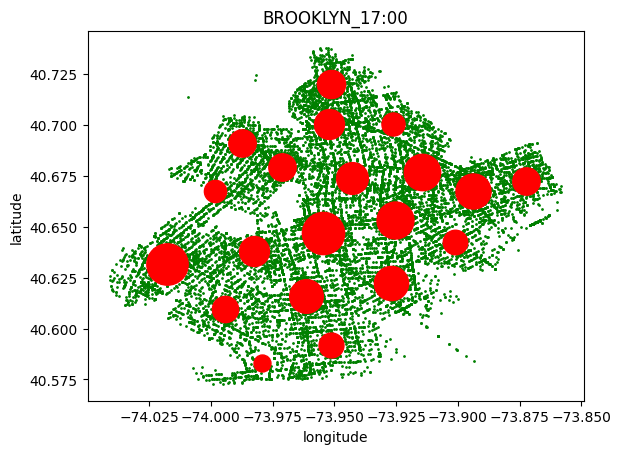

In [75]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_17:00")

In [76]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.70062807485031, -73.926342379491, 665],
 [40.674105384292034, -73.94270861736727, 915],
 [40.622194486598985, -73.92708462294418, 985],
 [40.63160286591101, -74.01793030596137, 1191],
 [40.61597691680412, -73.96149598371134, 970],
 [40.6724697937896, -73.87245466311788, 789],
 [40.691169846415086, -73.98745414767295, 788],
 [40.59187974902507, -73.95115539568246, 718],
 [40.65314333377234, -73.92537626914392, 1065],
 [40.63798142893518, -73.98235760775462, 864],
 [40.6095968436508, -73.99408524801586, 756],
 [40.700433273781904, -73.9520384048724, 862],
 [40.67672212842003, -73.91449439402696, 1048],
 [40.642381334702556, -73.90093970495751, 706],
 [40.66745454021739, -73.99820530900621, 640],
 [40.67938127409713, -73.97137735803237, 790],
 [40.720127350924784, -73.95126432108508, 812],
 [40.64671015955519, -73.95448000280068, 1217],
 [40.58302526768916, -73.97935867832314, 489],
 [40.66743629554895, -73.89364504846685, 1011]]

### 18:00

In [77]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='18:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
| 40.63654| -73.97707|BROOKLYN|18:00:00|[40.63654,-73.97707]|
| 40.69831|  -73.9498|BROOKLYN|18:00:00| [40.69831,-73.9498]|
| 40.66447| -73.89593|BROOKLYN|18:00:00|[40.66447,-73.89593]|
| 40.72937|-73.955444|BROOKLYN|18:00:00|[40.72937,-73.955...|
|  40.6544| -73.92044|BROOKLYN|18:00:00| [40.6544,-73.92044]|
| 40.67562| -73.88826|BROOKLYN|18:00:00|[40.67562,-73.88826]|
|40.686928|-73.920815|BROOKLYN|18:00:00|[40.686928,-73.92...|
| 40.70955| -73.95887|BROOKLYN|18:00:00|[40.70955,-73.95887]|
|40.638268| -73.93187|BROOKLYN|18:00:00|[40.638268,-73.93...|
|40.596977| -73.97324|BROOKLYN|18:00:00|[40.596977,-73.97...|
| 40.63532| -73.95033|BROOKLYN|18:00:00|[40.63532,-73.95033]|
|40.633152| -73.97762|BROOKLYN|18:00:00|[40.633152,-73.97...|
|40.576626| -73.98478|BROOKLYN|18:00:00|[40.576626,-73.98...|
|40.6884

In [78]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
| 40.63654| -73.97707|BROOKLYN|18:00:00|[40.63654,-73.97707]|        16|
| 40.69831|  -73.9498|BROOKLYN|18:00:00| [40.69831,-73.9498]|         3|
| 40.66447| -73.89593|BROOKLYN|18:00:00|[40.66447,-73.89593]|        12|
| 40.72937|-73.955444|BROOKLYN|18:00:00|[40.72937,-73.955...|         3|
|  40.6544| -73.92044|BROOKLYN|18:00:00| [40.6544,-73.92044]|         1|
| 40.67562| -73.88826|BROOKLYN|18:00:00|[40.67562,-73.88826]|         5|
|40.686928|-73.920815|BROOKLYN|18:00:00|[40.686928,-73.92...|        10|
| 40.70955| -73.95887|BROOKLYN|18:00:00|[40.70955,-73.95887]|         3|
|40.638268| -73.93187|BROOKLYN|18:00:00|[40.638268,-73.93...|         0|
|40.596977| -73.97324|BROOKLYN|18:00:00|[40.596977,-73.97...|        13|
| 40.63532| -73.95033|BROOKLYN|18:00:00|[40.63532,-

Text(0.5, 1.0, 'BROOKLYN_18:00')

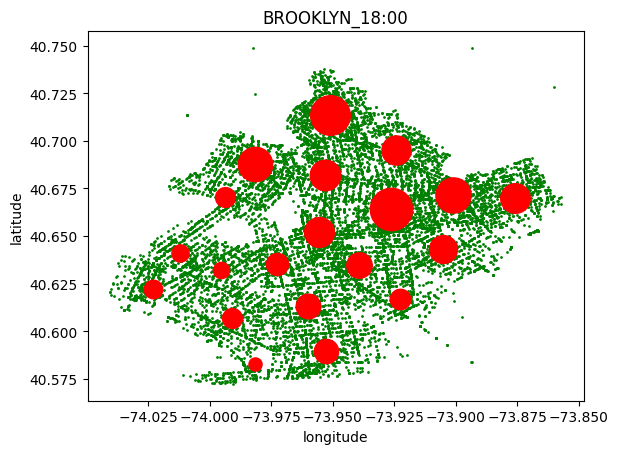

In [79]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_18:00")

In [80]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.634840556343796, -73.93917976343792, 733],
 [40.66415476267432, -73.92651106882691, 1219],
 [40.613122376760565, -73.96024779802819, 710],
 [40.71350372029876, -73.95107983427064, 1140],
 [40.67072973537654, -73.99383060262697, 571],
 [40.67007250868545, -73.87596305563382, 854],
 [40.65238012299652, -73.9555629962834, 861],
 [40.61692632359933, -73.92256806910017, 589],
 [40.6412693426, -74.01212553239999, 496],
 [40.632253102123144, -73.99531117728239, 468],
 [40.695134044761915, -73.92444157428571, 840],
 [40.68787256751012, -73.98177292884617, 988],
 [40.671323403543305, -73.90128690915353, 1015],
 [40.58292203007916, -73.98175223456464, 379],
 [40.643458448074526, -73.90511682906833, 805],
 [40.607138046073295, -73.99102434677137, 573],
 [40.635481388818896, -73.9724665303937, 635],
 [40.62242571768061, -74.02310649524715, 533],
 [40.681959721493214, -73.95331836821268, 881],
 [40.58942166504298, -73.95265490444127, 698]]

### 19:00

In [81]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='19:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
| 40.65011|-73.930214|BROOKLYN|19:00:00|[40.65011,-73.930...|
| 40.69538|-73.985115|BROOKLYN|19:00:00|[40.69538,-73.985...|
|40.617645| -73.92092|BROOKLYN|19:00:00|[40.617645,-73.92...|
|40.638428| -73.91275|BROOKLYN|19:00:00|[40.638428,-73.91...|
| 40.68164| -73.98568|BROOKLYN|19:00:00|[40.68164,-73.98568]|
| 40.65375|-73.931274|BROOKLYN|19:00:00|[40.65375,-73.931...|
|40.642044| -73.98124|BROOKLYN|19:00:00|[40.642044,-73.98...|
| 40.69484| -73.98391|BROOKLYN|19:00:00|[40.69484,-73.98391]|
| 40.64721| -74.01531|BROOKLYN|19:00:00|[40.64721,-74.01531]|
|40.668976| -73.90668|BROOKLYN|19:00:00|[40.668976,-73.90...|
|40.666737| -73.90224|BROOKLYN|19:00:00|[40.666737,-73.90...|
| 40.64884| -73.95102|BROOKLYN|19:00:00|[40.64884,-73.95102]|
|40.633514|-74.026955|BROOKLYN|19:00:00|[40.633514,-74.02...|
| 40.719

In [82]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
| 40.65011|-73.930214|BROOKLYN|19:00:00|[40.65011,-73.930...|         6|
| 40.69538|-73.985115|BROOKLYN|19:00:00|[40.69538,-73.985...|        11|
|40.617645| -73.92092|BROOKLYN|19:00:00|[40.617645,-73.92...|        13|
|40.638428| -73.91275|BROOKLYN|19:00:00|[40.638428,-73.91...|         2|
| 40.68164| -73.98568|BROOKLYN|19:00:00|[40.68164,-73.98568]|        11|
| 40.65375|-73.931274|BROOKLYN|19:00:00|[40.65375,-73.931...|         6|
|40.642044| -73.98124|BROOKLYN|19:00:00|[40.642044,-73.98...|        14|
| 40.69484| -73.98391|BROOKLYN|19:00:00|[40.69484,-73.98391]|        11|
| 40.64721| -74.01531|BROOKLYN|19:00:00|[40.64721,-74.01531]|        10|
|40.668976| -73.90668|BROOKLYN|19:00:00|[40.668976,-73.90...|        18|
|40.666737| -73.90224|BROOKLYN|19:00:00|[40.666737,

Text(0.5, 1.0, 'BROOKLYN_19:00')

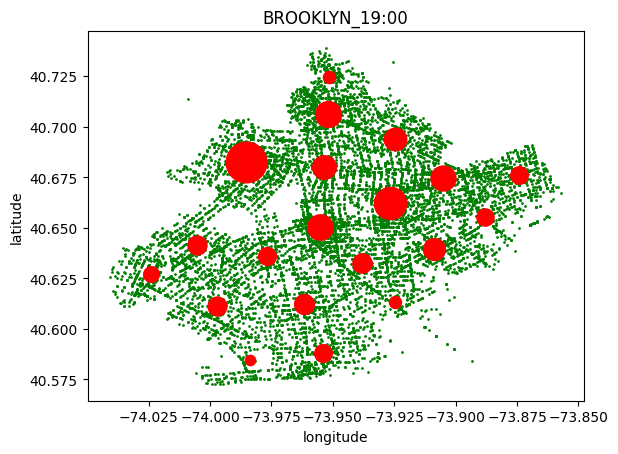

In [83]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_19:00")

In [84]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.61212223012259, -73.96187402049038, 573],
 [40.69401373235748, -73.92480740801236, 649],
 [40.63962294111112, -73.9086184626984, 630],
 [40.62689665759493, -74.02391106054851, 450],
 [40.65044630054794, -73.95503925643835, 732],
 [40.67986679396171, -73.95358333726068, 680],
 [40.66204557672414, -73.9267680632543, 928],
 [40.65541476754032, -73.8881719233871, 496],
 [40.584343988175675, -73.98357088614866, 296],
 [40.61103898749999, -73.99709871746323, 544],
 [40.641458371673004, -74.00525283840305, 547],
 [40.682463288983776, -73.98538609931683, 1171],
 [40.72460919173789, -73.95143329031339, 351],
 [40.61318354840581, -73.92453212405798, 345],
 [40.636213486575876, -73.9768088885214, 512],
 [40.67583137207921, -73.87437347920793, 505],
 [40.70627382298387, -73.95182938198926, 744],
 [40.63267029371634, -73.93795726140036, 557],
 [40.67461202916666, -73.90515270208333, 720],
 [40.58797195461688, -73.95419956404714, 509]]

### 20:00

In [85]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='20:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
| 40.65068| -73.95881|BROOKLYN|20:00:00|[40.65068,-73.95881]|
| 40.66576|  -73.9845|BROOKLYN|20:00:00| [40.66576,-73.9845]|
|40.666256|-73.900215|BROOKLYN|20:00:00|[40.666256,-73.90...|
| 40.59207| -73.96299|BROOKLYN|20:00:00|[40.59207,-73.96299]|
|40.680664|-73.902626|BROOKLYN|20:00:00|[40.680664,-73.90...|
|40.668495|-73.925606|BROOKLYN|20:00:00|[40.668495,-73.92...|
| 40.68821| -73.96583|BROOKLYN|20:00:00|[40.68821,-73.96583]|
|40.681602| -73.95855|BROOKLYN|20:00:00|[40.681602,-73.95...|
|40.601128|-73.997086|BROOKLYN|20:00:00|[40.601128,-73.99...|
| 40.64739| -73.92314|BROOKLYN|20:00:00|[40.64739,-73.92314]|
|  40.6481| -73.91474|BROOKLYN|20:00:00| [40.6481,-73.91474]|
|40.682842|  -73.9766|BROOKLYN|20:00:00|[40.682842,-73.9766]|
|40.682156|-73.920616|BROOKLYN|20:00:00|[40.682156,-73.92...|
| 40.653

In [86]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
| 40.65068| -73.95881|BROOKLYN|20:00:00|[40.65068,-73.95881]|        19|
| 40.66576|  -73.9845|BROOKLYN|20:00:00| [40.66576,-73.9845]|         2|
|40.666256|-73.900215|BROOKLYN|20:00:00|[40.666256,-73.90...|         3|
| 40.59207| -73.96299|BROOKLYN|20:00:00|[40.59207,-73.96299]|         6|
|40.680664|-73.902626|BROOKLYN|20:00:00|[40.680664,-73.90...|         3|
|40.668495|-73.925606|BROOKLYN|20:00:00|[40.668495,-73.92...|         9|
| 40.68821| -73.96583|BROOKLYN|20:00:00|[40.68821,-73.96583]|        11|
|40.681602| -73.95855|BROOKLYN|20:00:00|[40.681602,-73.95...|         8|
|40.601128|-73.997086|BROOKLYN|20:00:00|[40.601128,-73.99...|         4|
| 40.64739| -73.92314|BROOKLYN|20:00:00|[40.64739,-73.92314]|        13|
|  40.6481| -73.91474|BROOKLYN|20:00:00| [40.6481,-

Text(0.5, 1.0, 'BROOKLYN_20:00')

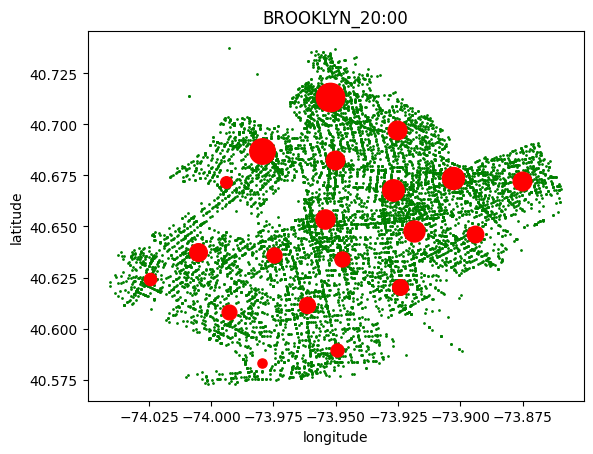

In [87]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_20:00")

In [88]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.63619732304147, -73.9748995016129, 434],
 [40.71350828247548, -73.9523363872549, 816],
 [40.67155045568863, -73.99419308233533, 334],
 [40.67364156985646, -73.90305771562998, 633],
 [40.60822431482353, -73.99288510564705, 425],
 [40.6461841450106, -73.8940173418259, 475],
 [40.589771524, -73.94959768053332, 375],
 [40.67241202574626, -73.87515904328359, 537],
 [40.682554729291056, -73.95046481716416, 533],
 [40.667687309952605, -73.92713930394945, 619],
 [40.620270362499994, -73.9241442546875, 450],
 [40.687087207901904, -73.97952688242505, 733],
 [40.63396840873564, -73.94757127126437, 433],
 [40.6479203984874, -73.9185713477311, 603],
 [40.697093221033214, -73.92534071365314, 539],
 [40.637307778937, -74.00521071043308, 508],
 [40.58323461704545, -73.97961642613637, 264],
 [40.624074203682724, -74.02460558640229, 353],
 [40.61160947835498, -73.96135662337662, 461],
 [40.65361198439202, -73.95440056261343, 554]]

### 21:00

In [89]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='21:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+------------------+--------+--------+--------------------+
| latitude|         longitude| borough|    time|            features|
+---------+------------------+--------+--------+--------------------+
| 40.67172|          -73.8971|BROOKLYN|21:00:00| [40.67172,-73.8971]|
|40.668896|         -73.95339|BROOKLYN|21:00:00|[40.668896,-73.95...|
|40.629475|        -74.004166|BROOKLYN|21:00:00|[40.629475,-74.00...|
|40.609985|         -73.96239|BROOKLYN|21:00:00|[40.609985,-73.96...|
|40.732006|         -73.95795|BROOKLYN|21:00:00|[40.732006,-73.95...|
| 40.66169|-73.96143000000001|BROOKLYN|21:00:00|[40.66169,-73.961...|
|40.700356|         -73.95732|BROOKLYN|21:00:00|[40.700356,-73.95...|
|40.651707|         -73.93121|BROOKLYN|21:00:00|[40.651707,-73.93...|
| 40.65785|         -73.91648|BROOKLYN|21:00:00|[40.65785,-73.91648]|
| 40.69097|         -73.94833|BROOKLYN|21:00:00|[40.69097,-73.94833]|
|40.655285|         -73.93658|BROOKLYN|21:00:00|[40.655285,-73.93...|
|40.649788|         

In [90]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+------------------+--------+--------+--------------------+----------+
| latitude|         longitude| borough|    time|            features|prediction|
+---------+------------------+--------+--------+--------------------+----------+
| 40.67172|          -73.8971|BROOKLYN|21:00:00| [40.67172,-73.8971]|         2|
|40.668896|         -73.95339|BROOKLYN|21:00:00|[40.668896,-73.95...|         6|
|40.629475|        -74.004166|BROOKLYN|21:00:00|[40.629475,-74.00...|         3|
|40.609985|         -73.96239|BROOKLYN|21:00:00|[40.609985,-73.96...|        12|
|40.732006|         -73.95795|BROOKLYN|21:00:00|[40.732006,-73.95...|         0|
| 40.66169|-73.96143000000001|BROOKLYN|21:00:00|[40.66169,-73.961...|        11|
|40.700356|         -73.95732|BROOKLYN|21:00:00|[40.700356,-73.95...|         0|
|40.651707|         -73.93121|BROOKLYN|21:00:00|[40.651707,-73.93...|        16|
| 40.65785|         -73.91648|BROOKLYN|21:00:00|[40.65785,-73.91648]|         9|
| 40.69097|         -73.9483

Text(0.5, 1.0, 'BROOKLYN_21:00')

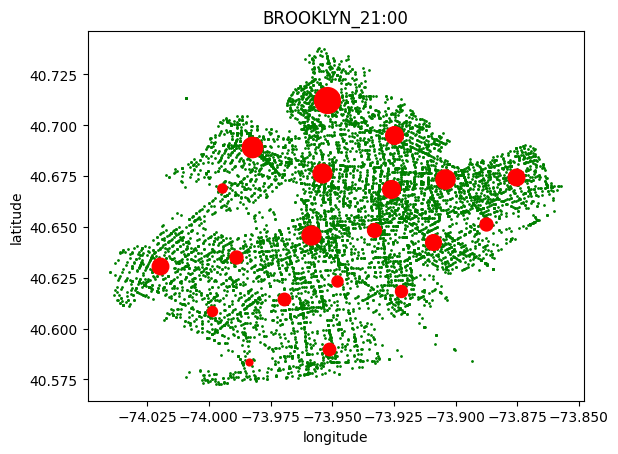

In [91]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_21:00")

In [92]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.712226121102155, -73.95213702405916, 743],
 [40.64268885, -73.90921002939915, 452],
 [40.67357131428571, -73.9042777461121, 553],
 [40.6305309892857, -74.01998570567227, 476],
 [40.65129538494623, -73.88759027607527, 373],
 [40.58968981512605, -73.95138177086835, 357],
 [40.676526133515495, -73.9541959564663, 541],
 [40.583397370256414, -73.9839294548718, 195],
 [40.61846116320475, -73.92231715430268, 345],
 [40.6684589990138, -73.92619439723866, 511],
 [40.6353732619303, -73.98898007989277, 374],
 [40.645774341142854, -73.95879444304764, 547],
 [40.614607045277786, -73.96939489500001, 360],
 [40.62351890382166, -73.94799238152868, 317],
 [40.69503140058708, -73.92479253913893, 508],
 [40.608697657291664, -73.99876499895834, 288],
 [40.64852376560977, -73.93310599780486, 400],
 [40.66901140957854, -73.99480422337163, 261],
 [40.67475831517671, -73.87544157463618, 478],
 [40.68926693452992, -73.98272613111111, 585]]

### 22:00

In [93]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='22:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+------------------+----------+--------+--------+--------------------+
|          latitude| longitude| borough|    time|            features|
+------------------+----------+--------+--------+--------------------+
|          40.67848| -73.98232|BROOKLYN|22:00:00|[40.67848,-73.98232]|
|          40.68686| -73.96758|BROOKLYN|22:00:00|[40.68686,-73.96758]|
|          40.62318| -73.98611|BROOKLYN|22:00:00|[40.62318,-73.98611]|
|40.697540000000004| -73.98312|BROOKLYN|22:00:00|[40.6975400000000...|
|         40.626457|   -73.918|BROOKLYN|22:00:00| [40.626457,-73.918]|
|          40.66895|  -73.9339|BROOKLYN|22:00:00| [40.66895,-73.9339]|
|          40.65989| -73.90536|BROOKLYN|22:00:00|[40.65989,-73.90536]|
|         40.637234| -73.97266|BROOKLYN|22:00:00|[40.637234,-73.97...|
|         40.696983|-73.935234|BROOKLYN|22:00:00|[40.696983,-73.93...|
|         40.673252| -73.87773|BROOKLYN|22:00:00|[40.673252,-73.87...|
|         40.629105|-74.034645|BROOKLYN|22:00:00|[40.629105,-74.03...|
|     

In [94]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+------------------+----------+--------+--------+--------------------+----------+
|          latitude| longitude| borough|    time|            features|prediction|
+------------------+----------+--------+--------+--------------------+----------+
|          40.67848| -73.98232|BROOKLYN|22:00:00|[40.67848,-73.98232]|        16|
|          40.68686| -73.96758|BROOKLYN|22:00:00|[40.68686,-73.96758]|        16|
|          40.62318| -73.98611|BROOKLYN|22:00:00|[40.62318,-73.98611]|        11|
|40.697540000000004| -73.98312|BROOKLYN|22:00:00|[40.6975400000000...|         3|
|         40.626457|   -73.918|BROOKLYN|22:00:00| [40.626457,-73.918]|         2|
|          40.66895|  -73.9339|BROOKLYN|22:00:00| [40.66895,-73.9339]|         9|
|          40.65989| -73.90536|BROOKLYN|22:00:00|[40.65989,-73.90536]|         8|
|         40.637234| -73.97266|BROOKLYN|22:00:00|[40.637234,-73.97...|        10|
|         40.696983|-73.935234|BROOKLYN|22:00:00|[40.696983,-73.93...|        15|
|         40.673

Text(0.5, 1.0, 'BROOKLYN_22:00')

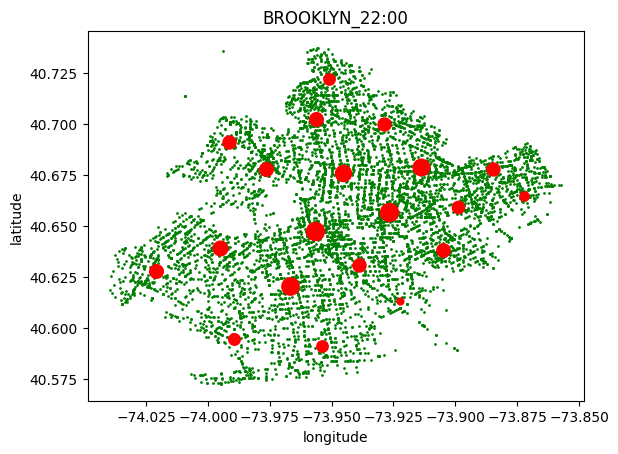

In [95]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_22:00")

In [96]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.657001834749025, -73.92664959015445, 519],
 [40.627771825699746, -74.0212032249364, 393],
 [40.61329774285714, -73.9225402260204, 195],
 [40.69097844654256, -73.99143751675531, 376],
 [40.66466865355806, -73.87210592808988, 267],
 [40.64725853269231, -73.95671872346153, 519],
 [40.72193489296636, -73.9508905003058, 327],
 [40.67769532580646, -73.8845906513441, 372],
 [40.659337664606745, -73.89896310786517, 356],
 [40.676062146420826, -73.94550899088937, 464],
 [40.62052826217304, -73.96702784144868, 498],
 [40.6390277521327, -73.99520013246446, 423],
 [40.594618829819275, -73.98967373403616, 332],
 [40.63815054871134, -73.90486104278351, 385],
 [40.7025954524173, -73.95648125292622, 393],
 [40.70012898997362, -73.92891174379946, 376],
 [40.67774302710997, -73.97663078465473, 391],
 [40.6306307778364, -73.93877027255938, 378],
 [40.591118204907986, -73.95406181656443, 329],
 [40.678750378870284, -73.9139905433054, 478]]

### 23:00

In [97]:
loc_0 = df1.rdd.filter(lambda x: x[3]=='23:00:00')
loc_0 = loc_0.filter(lambda x: x[2]=="BROOKLYN")
loc_0 = loc_0.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
loc_0 = loc_0.map(lambda x: [x[0], x[1], x[2], x[3]])

loc_loc = loc_0.toDF(["latitude","longitude", "borough", "time"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_loc)
new_df.show()

+---------+----------+--------+--------+--------------------+
| latitude| longitude| borough|    time|            features|
+---------+----------+--------+--------+--------------------+
|40.640835| -73.98967|BROOKLYN|23:00:00|[40.640835,-73.98...|
| 40.67392| -73.91012|BROOKLYN|23:00:00|[40.67392,-73.91012]|
|40.616295| -73.92991|BROOKLYN|23:00:00|[40.616295,-73.92...|
|40.682724| -73.88539|BROOKLYN|23:00:00|[40.682724,-73.88...|
|40.649788|  -73.9622|BROOKLYN|23:00:00|[40.649788,-73.9622]|
|40.698986| -73.91671|BROOKLYN|23:00:00|[40.698986,-73.91...|
|40.683174| -73.87389|BROOKLYN|23:00:00|[40.683174,-73.87...|
|40.650703|-73.920586|BROOKLYN|23:00:00|[40.650703,-73.92...|
| 40.64588| -73.95195|BROOKLYN|23:00:00|[40.64588,-73.95195]|
|40.733376| -73.95865|BROOKLYN|23:00:00|[40.733376,-73.95...|
| 40.71418| -73.95336|BROOKLYN|23:00:00|[40.71418,-73.95336]|
|40.648075| -73.95959|BROOKLYN|23:00:00|[40.648075,-73.95...|
|40.692783| -73.91181|BROOKLYN|23:00:00|[40.692783,-73.91...|
|40.6741

In [98]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------+--------+--------------------+----------+
| latitude| longitude| borough|    time|            features|prediction|
+---------+----------+--------+--------+--------------------+----------+
|40.640835| -73.98967|BROOKLYN|23:00:00|[40.640835,-73.98...|        15|
| 40.67392| -73.91012|BROOKLYN|23:00:00|[40.67392,-73.91012]|         5|
|40.616295| -73.92991|BROOKLYN|23:00:00|[40.616295,-73.92...|         1|
|40.682724| -73.88539|BROOKLYN|23:00:00|[40.682724,-73.88...|         7|
|40.649788|  -73.9622|BROOKLYN|23:00:00|[40.649788,-73.9622]|        19|
|40.698986| -73.91671|BROOKLYN|23:00:00|[40.698986,-73.91...|        16|
|40.683174| -73.87389|BROOKLYN|23:00:00|[40.683174,-73.87...|         7|
|40.650703|-73.920586|BROOKLYN|23:00:00|[40.650703,-73.92...|         0|
| 40.64588| -73.95195|BROOKLYN|23:00:00|[40.64588,-73.95195]|        17|
|40.733376| -73.95865|BROOKLYN|23:00:00|[40.733376,-73.95...|         4|
| 40.71418| -73.95336|BROOKLYN|23:00:00|[40.71418,-

Text(0.5, 1.0, 'BROOKLYN_23:00')

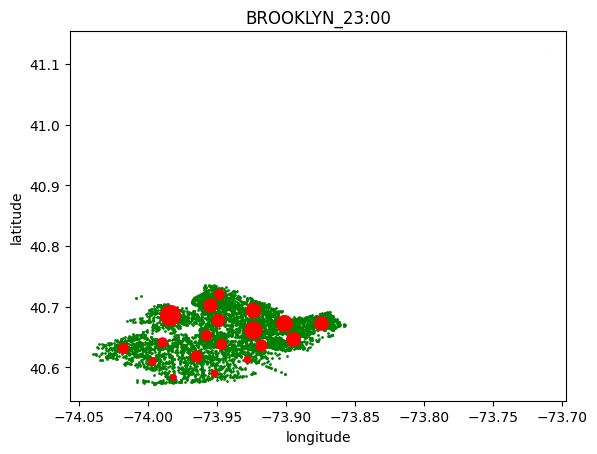

In [99]:
centers = model.clusterCenters()
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[5]]+=1

loc = loc_0.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/40)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_23:00")

In [100]:
center_list = []
idx = 0
for i in centers:
    temp = []
    temp.append(i[0])
    temp.append(i[1])
    temp.append(num[idx])
    idx+=1
    center_list.append(temp)
    
center_list

[[40.661991855809134, -73.92427837531118, 483],
 [40.613958952941175, -73.92871742727273, 185],
 [40.63197204405595, -74.01823736398602, 283],
 [40.67776503602305, -73.9497102129683, 348],
 [40.72074440392857, -73.94899689392858, 279],
 [40.6724075339207, -73.90137993722469, 452],
 [41.12615, -73.71353, 1],
 [40.67384061853786, -73.87472532402089, 380],
 [40.61102856226415, -73.99754974103774, 212],
 [40.63691332320262, -73.91852991797384, 312],
 [40.59142724, -73.95234786944444, 182],
 [40.68549105459364, -73.98448208339221, 566],
 [40.70274167621621, -73.95537586513514, 371],
 [40.64637313055555, -73.89530389065658, 390],
 [40.584496561963185, -73.9821669582822, 163],
 [40.64202979346154, -73.99003433692309, 263],
 [40.69492294926471, -73.92421687745097, 408],
 [40.638116034020626, -73.94757373436425, 282],
 [40.618547894805204, -73.96541780487013, 307],
 [40.65283189851302, -73.9583514464684, 282]]